## 0.0 IMPORTS

In [131]:
import pandas as  pd
import numpy as np
import inflection 
import math
import datetime

from scipy import stats
import seaborn as sns

from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.core.display import HTML
from IPython.display import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler

### 0.1 Helper Functions

In [113]:



def cramer_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


    
def jupyter_settings(): 
    %matplotlib inline


    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24


    display(HTML('<style>.container { width:100% !important; }</style>')) 
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()


In [57]:
jupyter_settings()

### 0.2 Loading Data

In [58]:
df_sales_raw = pd.read_csv('dataset/train.csv',low_memory=False)
df_store_raw = pd.read_csv('dataset/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 DESCRICAO DOS DADOS

In [59]:
df1 = df_raw.copy()

### 1.1 Raneme columns

In [60]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']


def snakecase(x): return inflection.underscore(x)


cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

### 1.2. Data Dimensions

In [61]:
print(f'Number of Rows:',df1.shape[0])
print('Number of cols {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of cols 18


### 1.3 Data Types

In [62]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [63]:
df1['date'] = pd.to_datetime(df1['date'])


### 1.4. Check NA

In [64]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5. Fillout NA

* CompetitionDistance - distância em metros até a loja concorrente mais próxima
* CompetitionOpenSince[Month/Year] - fornece o ano e o mês aproximados da hora em que o concorrente mais próximo foi aberto
Promo - indica se uma loja está realizando uma promoção naquele dia
* Promo2 - Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = loja não está participando, 1 = loja está participando
* Promo2Since[Year/Week] - descreve o ano e a semana do calendário em que a loja começou a participar do Promo2
* PromoInterval - descreve os intervalos consecutivos em que o Promo2 é iniciado, nomeando os meses em que a promoção é reiniciada. Por exemplo. "Fevereiro, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para essa loja

In [65]:
# competition_distance   
df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month   
df1['competition_open_since_month'] = df1.apply( 
    lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'],axis=1)

# competition_open_since_year    
df1['competition_open_since_year'] = df1.apply(
    lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2                         

# promo2_since_week              
df1['promo2_since_week'] = df1.apply(
    lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year              
df1['promo2_since_year'] = df1.apply(
    lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# coluna mes em string, faz a troca do dicionario do ano para o nome do mes
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Out', 11: 'Nov', 12: 'Dez'}
# prenche com fillna para nao fazer comparacao com na e todos os na passa como 0 e true para ir diretamentente na coluna
df1['promo_interval'].fillna(0, inplace=True)
# mapear o dic dentro da coluna, transforma a data em date o.dt e depois em mes o month
# passa o month para mapear o dicionario dentro das colunas e que os numeros sejam substituido pelas letras.
df1['month_map'] = df1['date'].dt.month.map(month_map)# extraindo o mes da data, e aplivando o dic para fazer a traducao

# aplicando a condicao para ver se o month_map esta detro dessa condicao para saber se esta na promo ou nao 
# vai me retorna 1 ou zero pela regras de negocio aqui
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


### 1.6. Chenge types

In [66]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [67]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int) 


In [68]:
df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.7. Descriptive Statistics

In [69]:
num_atributes = df1.select_dtypes(include= ['int64','float64'])
cat_atributes = df1.select_dtypes(exclude= ['int64','float64', 'datetime64[ns]'])

### 1.7.1 Numerical Atributes

In [70]:
ct1 = pd.DataFrame( num_atributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_atributes.apply(np.median)).T

d1 = pd.DataFrame( num_atributes.apply(np.std) ).T
d2 = pd.DataFrame( num_atributes.apply(min)).T
d3 = pd.DataFrame( num_atributes.apply(max)).T
d4 = pd.DataFrame( num_atributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_atributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame( num_atributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['atributes','min','max','range','mean','median','std','skew','kurtose']
m

,atributes,min,max,range,mean,median,std,skew,kurtose
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/var/folders/cb/yv1tpd8j3sx6t0rsz1yystv00000gn/T/ipykernel_732/3052452695.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_distance'])#,kde=False)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

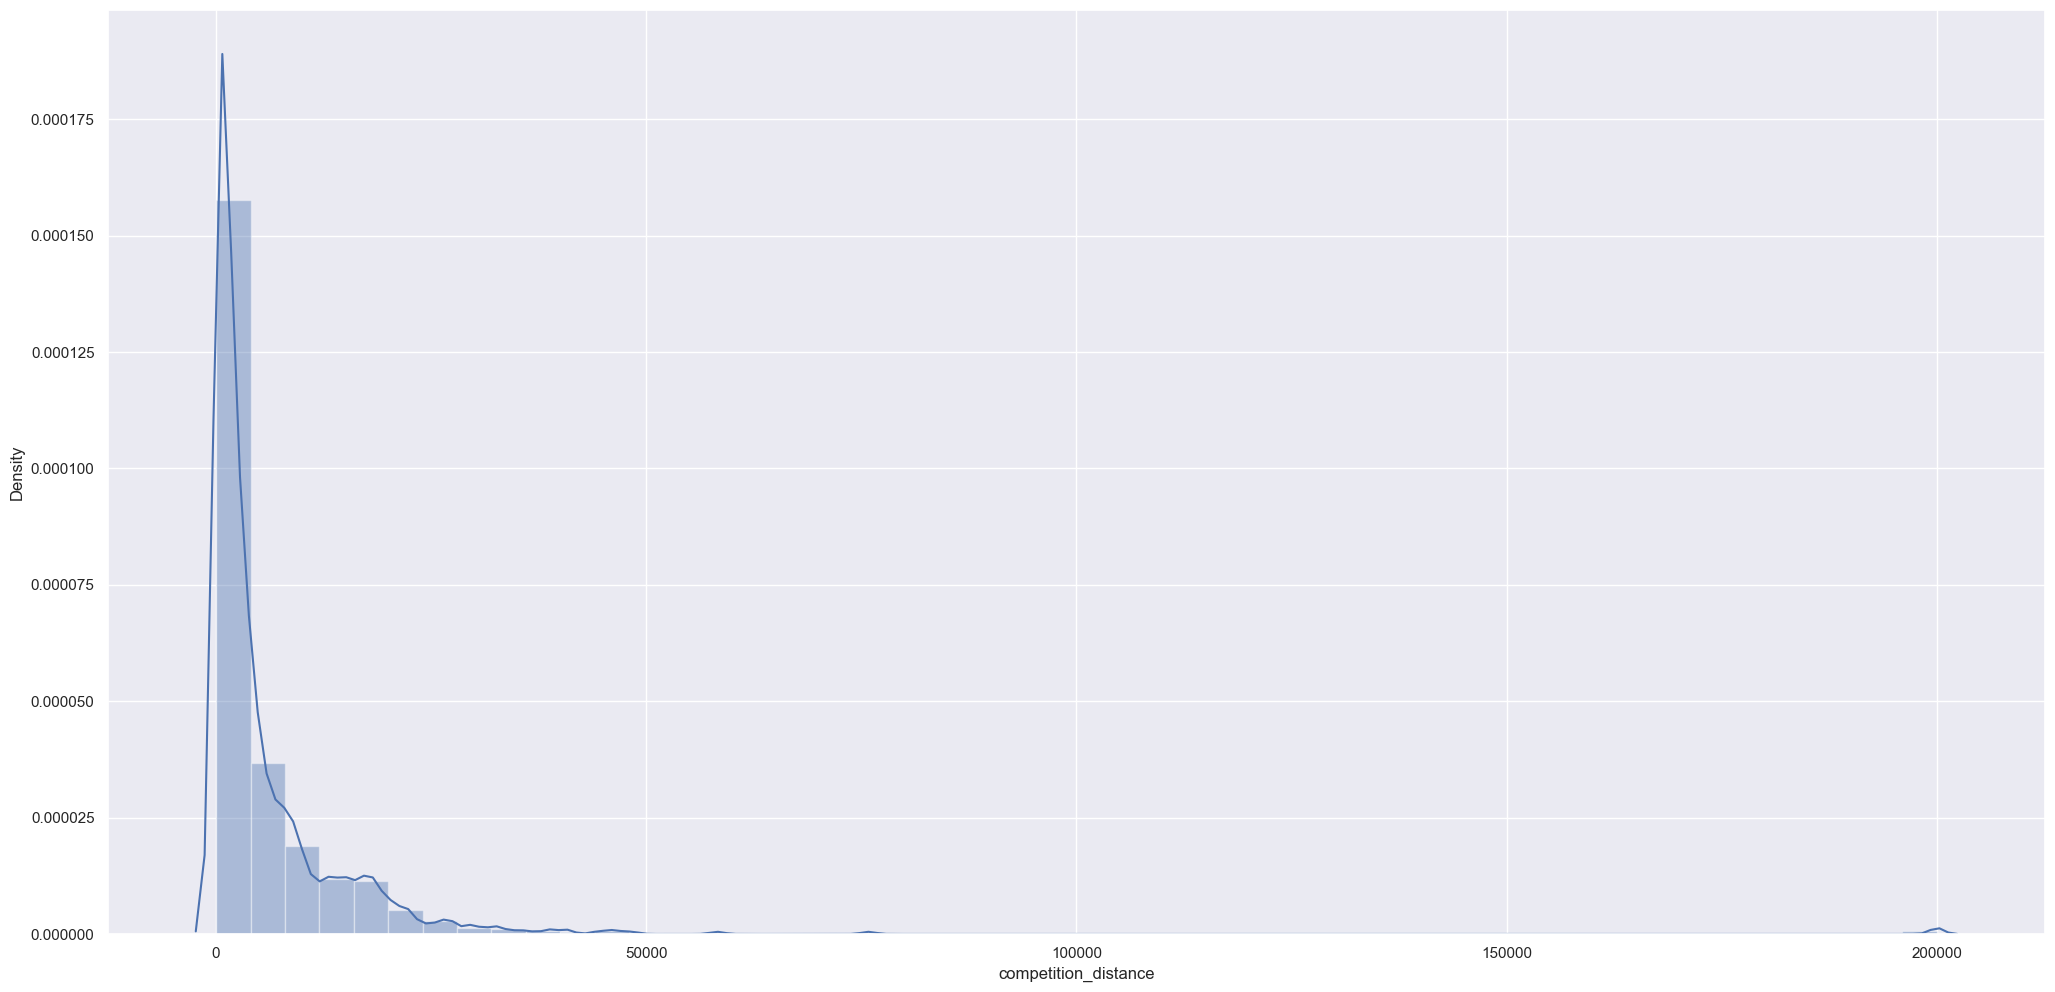

In [71]:
sns.distplot(df1['competition_distance'])#,kde=False)


## 1.7.2 Categorical Attributes

In [72]:
cat_atributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

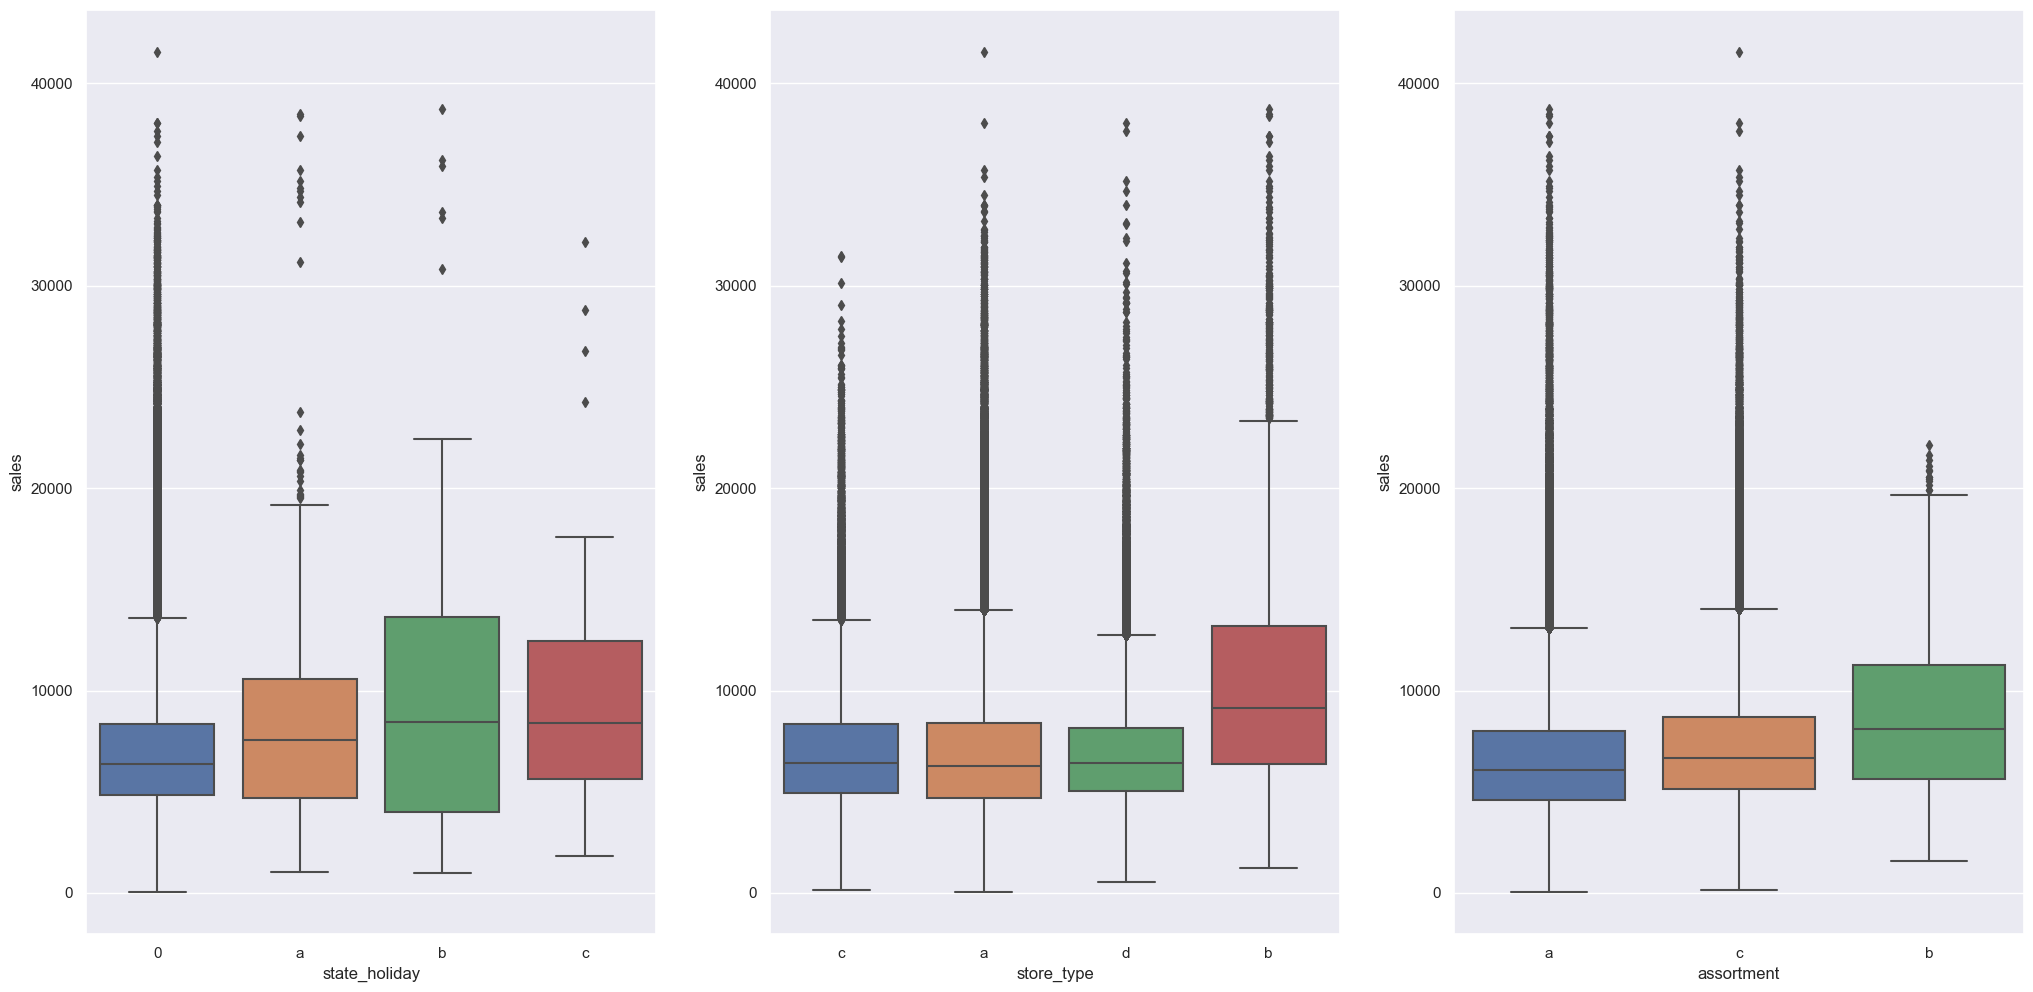

In [73]:
aux1 = df1[(df1['state_holiday']!= 0) & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)


plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)



# 2.0. Feature Engineering

In [74]:
df2 = df1.copy()

## 2.1. Mapa Mental Hipotese

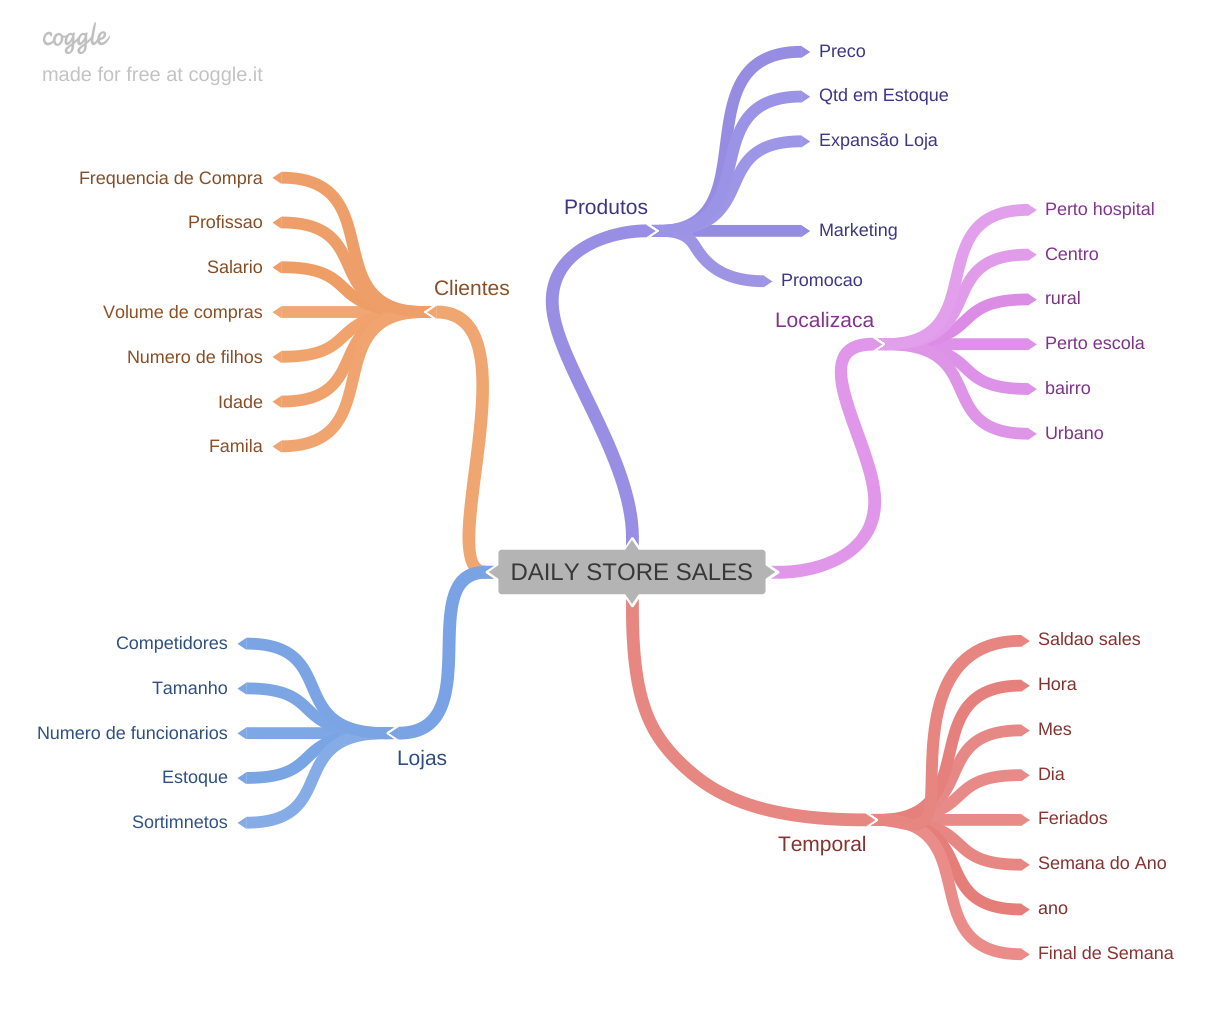

In [75]:
# Mindmap de hipoteses
Image('img/image.png')

### 2.2. Criação das Hipóteses

### 2.2.1. Hipoteses Loja


1. Lojas com número maior de funcionários deveriam vender mais.

2. Lojas com maior capacidade de estoque deveriam vender mais.

3. Lojas com maior porte deveriam vender mais.

4. Lojas com maior sortimentos deveriam vender mais.

5. Lojas com competidores mais próximos deveriam vender menos. 

6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipoteses Produto


1. Lojas que investem mais em Marketing deveriam vender mais.

2. Lojas com maior exposição de produto deveriam vender mais.

3. Lojas com produtos com preço menor deveriam vender mais.

5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

6. Lojas com promoções ativas por mais tempo deveriam vender mais.

7. Lojas com mais dias de promoção deveriam vender mais.

8. Lojas com mais promoções consecutivas deveriam vender mais.


### 2.2.3. Hipoteses Tempo



1. Lojas abertas durante o feriado de Natal deveriam vender mais. 

2. Lojas deveriam vender mais ao longo dos anos.

3. Lojas deveriam vender mais no segundo semestre do ano.

4. Lojas deveriam vender mais depois do dia 10 de cada mês.

5. Lojas deveriam vender menos aos finais de semana.

6. Lojas deveriam vender menos durante os feriados escolares.

### 2.2.3. Hipoteses Tempo



1. Lojas abertas durante o feriado de Natal deveriam vender mais. 2. Lojas deveriam vender mais ao longo dos anos.

3. Lojas deveriam vender mais no segundo semestre do ano.

4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.

6. Lojas deveriam vender menos durante os feriados escolares.



## 2.3. Lista Final de Hipóteses




1. Lojas com maior sortimentos deveriam vender mais.

2. Lojas com competidores mais próximos deveriam vender menos.

3. Lojas com competidores à mais tempo deveriam vendem mais.

4. Lojas com promoções ativas por mais tempo deveriam vender mais.

5. Lojas com mais dias de promoção deveriam vender mais.

7. Lojas com mais promoções consecutivas deveriam vender mais. 

8. Lojas abertas durante o feriado de Natal deveriam vender mais.

 9. Lojas deveriam vender mais ao longo dos anos.

10. Lojas deveriam vender mais no segundo semestre do ano.

11. Lojas deveriam vender mais depois do dia 10 de cada mês.

12. Lojas deveriam vender menos aos finais de semana.

13. Lojas deveriam vender menos durante os feriados escolares.

In [76]:
df2.sample(7)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
806027,668,2,2013-07-09,6736,942,1,0,0,1,c,a,1270.0,9,2010,0,28,2013,0,Jul,0
952537,1113,4,2013-02-28,6959,788,1,0,0,0,a,c,9260.0,2,2013,0,9,2013,0,Fev,0
107513,474,7,2015-04-26,0,0,0,0,0,0,c,a,14810.0,4,2015,1,14,2011,"Mar,Jun,Sept,Dec",Apr,0
73365,891,3,2015-05-27,5370,837,1,0,0,0,a,c,350.0,5,2015,1,31,2013,"Feb,May,Aug,Nov",May,1
505623,199,5,2014-04-04,9104,657,1,1,0,0,d,c,6360.0,12,2010,1,14,2012,"Mar,Jun,Sept,Dec",Apr,0
858789,1025,4,2013-05-23,6486,841,1,0,0,0,a,a,720.0,11,2009,0,21,2013,0,May,0
1007789,615,3,2013-01-09,9929,1208,1,1,0,1,d,a,730.0,8,2007,0,2,2013,0,Jan,0


## 2.4. Feature 

In [77]:
# year
df2['year'] = df2['date'].dt.year

# month_mapday
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(
    year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

df2['competition_time_month'] = (
    (df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days ).astype(int)
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christimas' if x == 'c' else 'regular_day')


In [78]:
df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
874928,439,3,2013-05-08,7133,960,1,0,regular_day,0,a,basic,1350.0,9,2009,0,19,2013,0,May,0,2013,5,8,19,2013-18,2009-09-01,44,2013-05-06,0
490858,1044,5,2014-04-18,0,0,0,1,easter_holiday,1,c,basic,240.0,4,2015,1,13,2010,"Jan,Apr,Jul,Oct",Apr,1,2014,4,18,16,2014-15,2015-04-01,-12,2010-03-22,212
844945,561,2,2013-06-04,7878,760,1,1,regular_day,0,d,basic,14300.0,6,2013,0,23,2013,0,Jun,0,2013,6,4,23,2013-22,2013-06-01,0,2013-06-03,0
334251,760,4,2014-09-18,6746,1156,1,1,regular_day,0,a,basic,560.0,1,2011,0,38,2014,0,Sep,0,2014,9,18,38,2014-37,2011-01-01,45,2014-09-15,0
543741,407,6,2014-03-01,3883,335,1,0,regular_day,0,a,basic,5890.0,10,2003,1,14,2011,"Feb,May,Aug,Nov",Mar,0,2014,3,1,9,2014-08,2003-10-01,126,2011-03-28,152


# 3.0. Filtragem de Variaveis

In [79]:
df3 = df2.copy()


## 3.1 Fitragem das Linhas

In [80]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]


## 3.2 Seleçao das colunas

In [81]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. Analise Exploratoria dos Dados

In [82]:
df4 = df3.copy()


## 4.1.Analise Univariada

In [83]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                            UInt32
year_week                               object
competition_s

### 4.1.1 Response Veriables

/var/folders/cb/yv1tpd8j3sx6t0rsz1yystv00000gn/T/ipykernel_732/2199176356.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales']);#,kde=False)


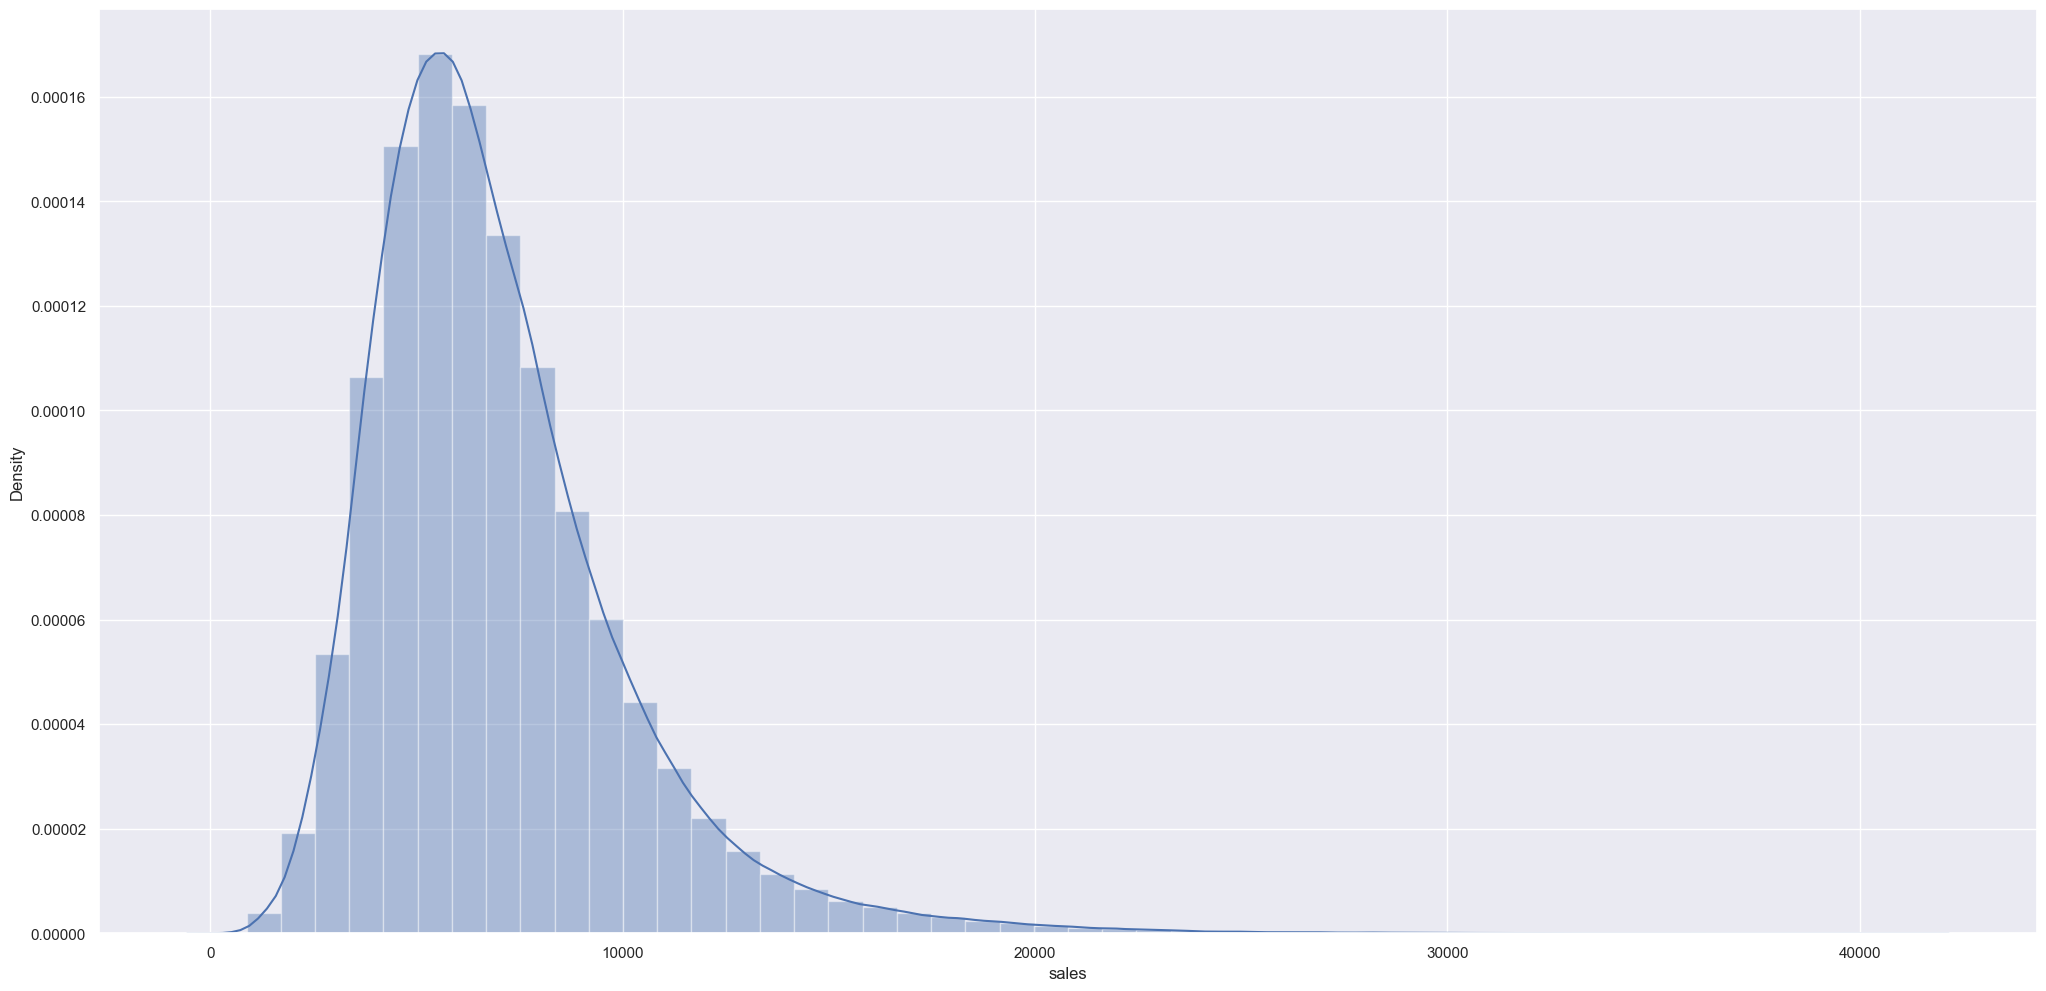

In [84]:
sns.distplot(df4['sales']);#,kde=False)

### 4.1.2 Numerical Veriables

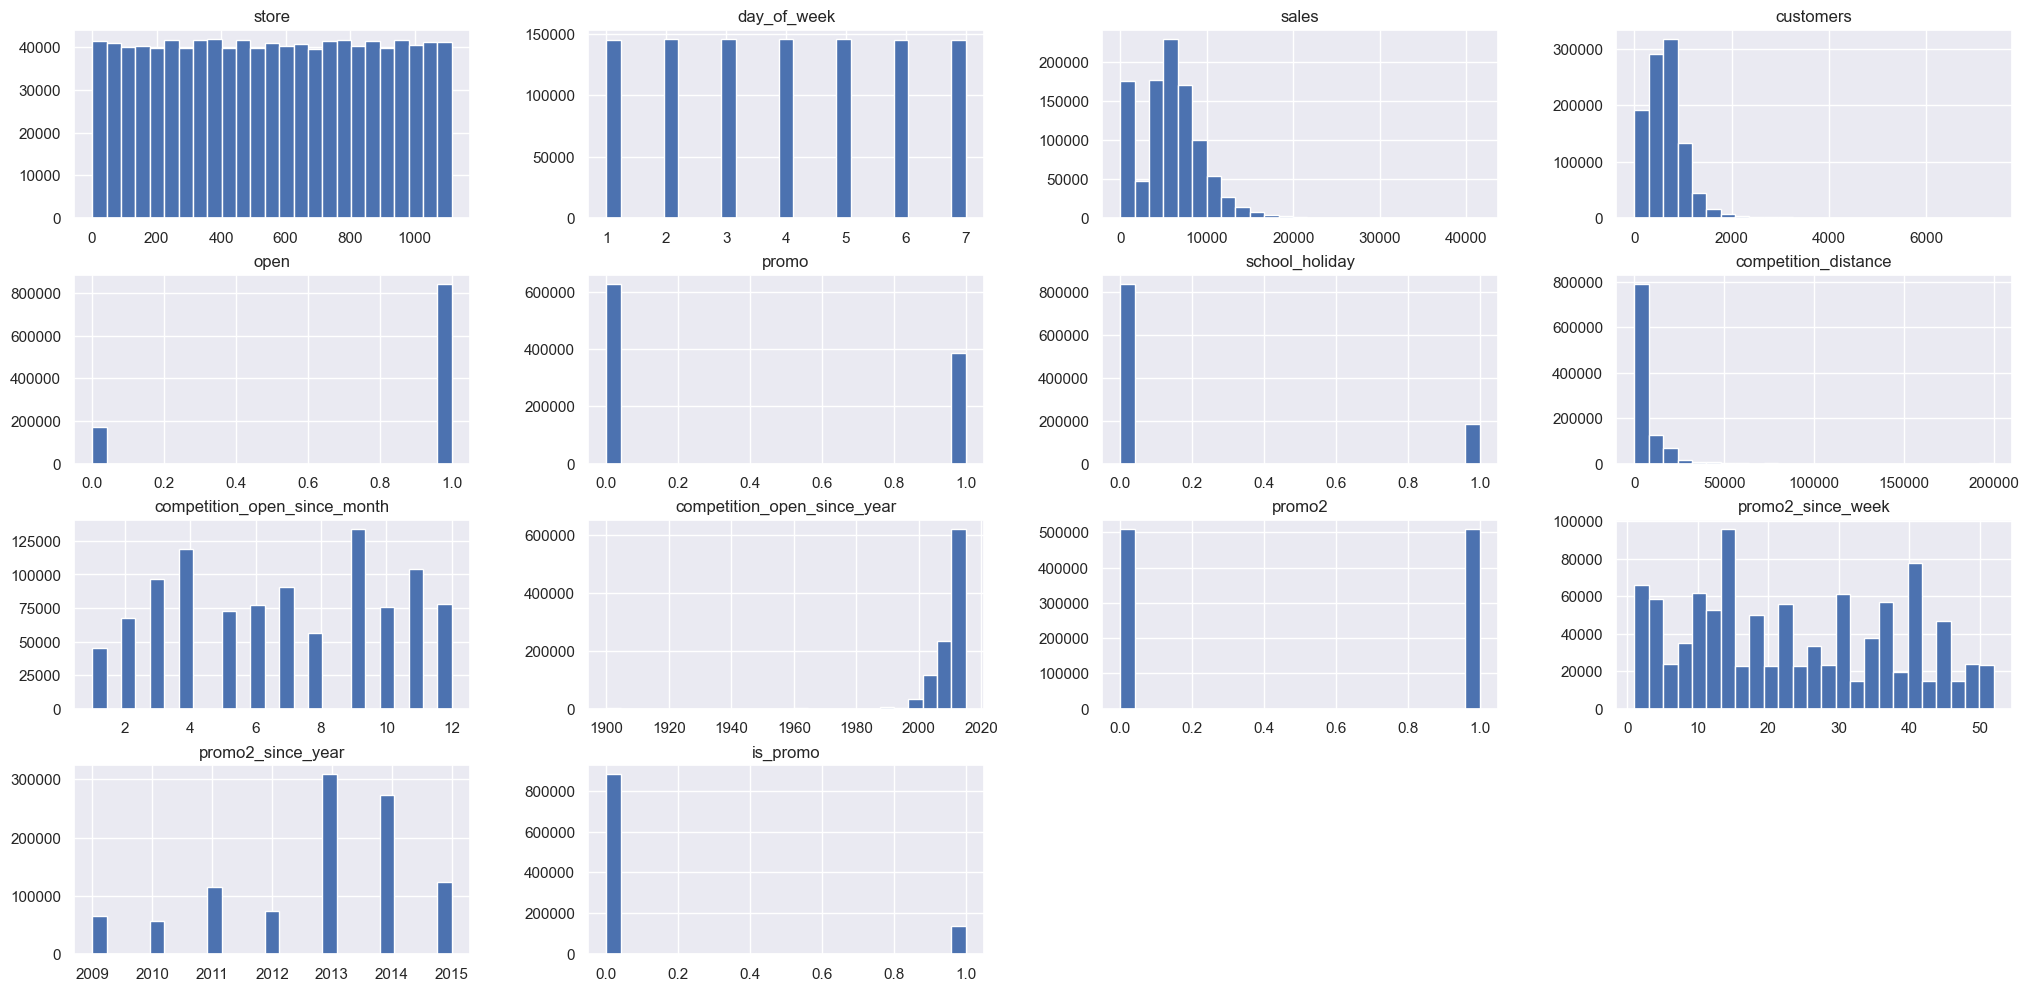

In [85]:
num_atributes.hist( bins=25 );

### 4.1.3 Categorical Veriables

In [86]:
cat_atributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


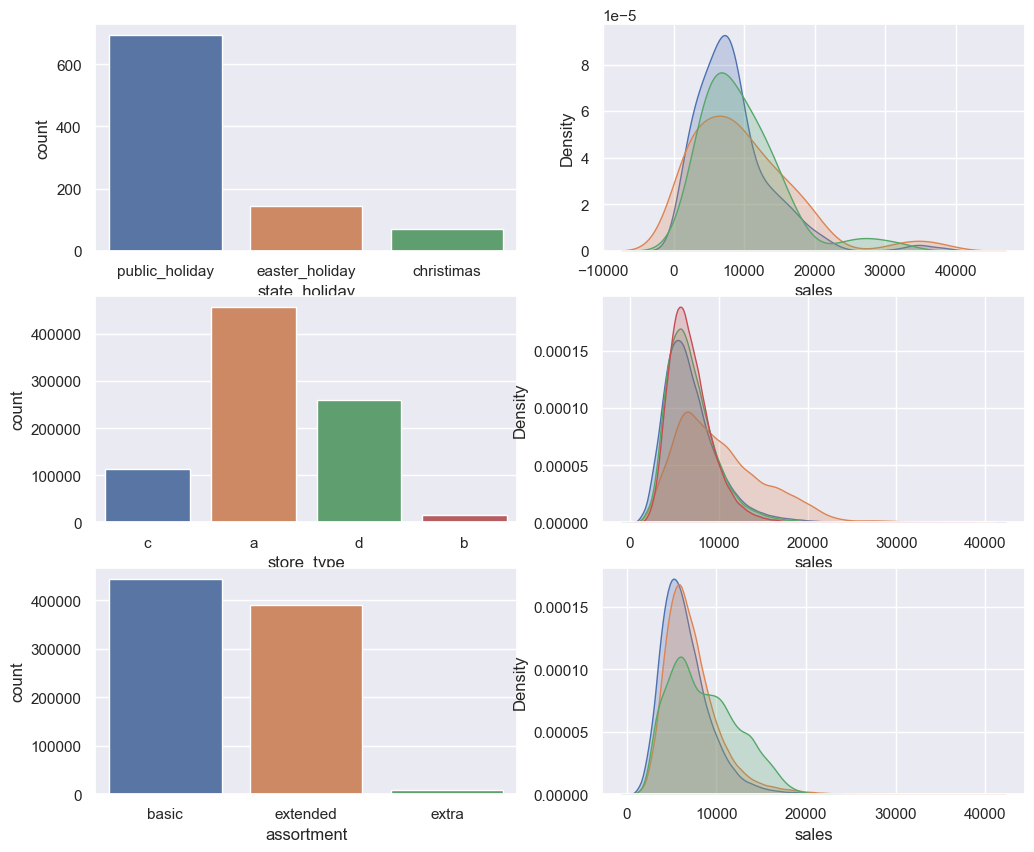

In [87]:
# state_holiday	

# Cria a grade de subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Adiciona o primeiro gráfico na posição (0, 0)
d = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=d, ax=axs[0, 0])

# Adiciona o segundo gráfico na posição (0, 1)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']
            ['sales'], label='public_holiday', fill=True, ax=axs[0, 1])

sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']
            ['sales'], label='easter_holiday', fill=True, ax=axs[0, 1])

sns.kdeplot(df4[df4['state_holiday'] == 'christimas']
            ['sales'],label='christimas', fill=True, ax=axs[0, 1])


# store_type

# Adiciona o terceiro gráfico na posição (1, 0)
sns.countplot(x='store_type', data=df4, ax=axs[1, 0])

# Adiciona o quarto gráfico na posição (1, 1)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],
            label='a', fill=True, ax=axs[1, 1])

sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],
            label='b', fill=True, ax=axs[1, 1])

sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],
            label='c', fill=True, ax=axs[1, 1])

sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],
            label='d', fill=True, ax=axs[1, 1])


# assortment
# Adiciona o quarto gráfico na posição (2, 0)
# b = df4[df4['assortment'] != 'basic']
sns.countplot(x= 'assortment',  data= df4, ax=axs[2,0])

# Adiciona o quarto gráfico na posição (2, 1)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label= 'basei' , fill=True, ax=axs[2,1])
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label= 'extended' , fill=True, ax=axs[2,1])
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label= 'extra' , fill=True, ax=axs[2,1])
    
plt.show()




## 4.2. Analise Univariada

In [88]:
# axis1 = df4.groupby('assortment')['sales'].sum().reset_index()


# #Criando o gráfico de barras com o Seaborn
# sns.barplot(x='assortment', y='sales', data=axis1)

# # Adicionando as contagens nas barras
# for index, row in axis1.iterrows():
#     plt.annotate(row['sales'], xy=(row.name, row['sales']),
#                  ha='center', va='bottom')

# # Exibindo o gráfico
# plt.show()


### **H1.** Lojas com maior sortimentos deveriam vender mais.

**FALSE**   - Lojas com maior sortimentos deveriam vendem menos.

/var/folders/cb/yv1tpd8j3sx6t0rsz1yystv00000gn/T/ipykernel_732/2854846740.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  aux2 = df4.groupby(['year_week', 'assortment'])[


Text(0.5, 1.0, 'Gráfico de Linhas unico')

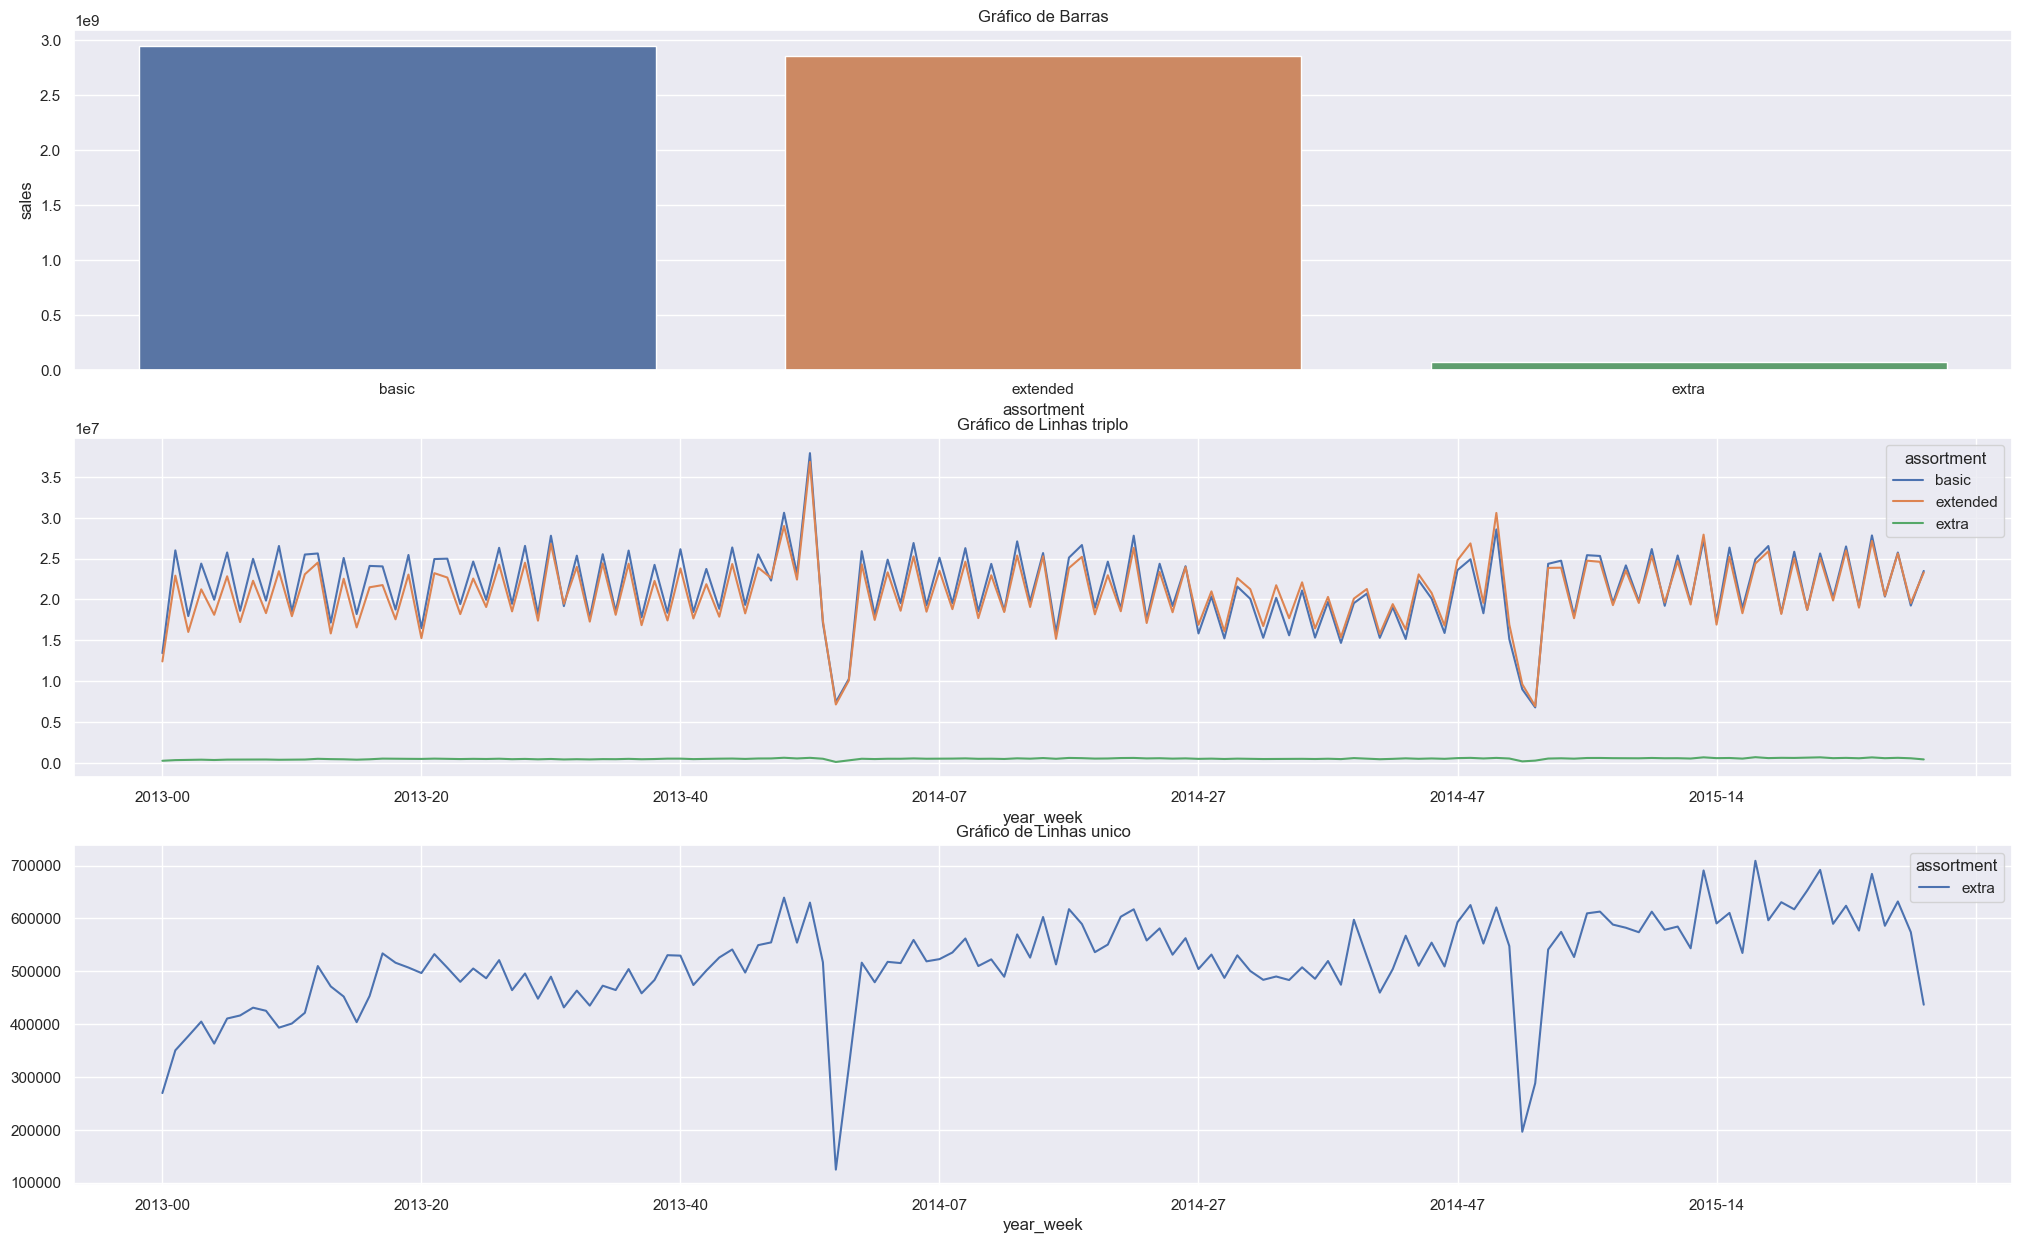

In [89]:

# Criando a figura e os subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,  figsize=(25, 15))

# Plotando o primeiro gráfico no primeiro subplot
aux1 = df4.groupby('assortment')['sales'].sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1, ax=ax1);
ax1.set_title('Gráfico de Barras')

# Plotando o segundo gráfico no segundo subplot
aux2 = df4.groupby(['year_week', 'assortment'])[
    'sales', 'assortment', 'year_week'].sum().reset_index()
aux2.pivot(index='year_week', columns='assortment',
            values='sales').plot(ax=ax2);
ax2.set_title('Gráfico de Linhas triplo')


aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment',
           values='sales').plot(ax=ax3);
ax3.set_title('Gráfico de Linhas unico')


### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**False** Lojas com competidores mais próximos deveriam vendem mais.

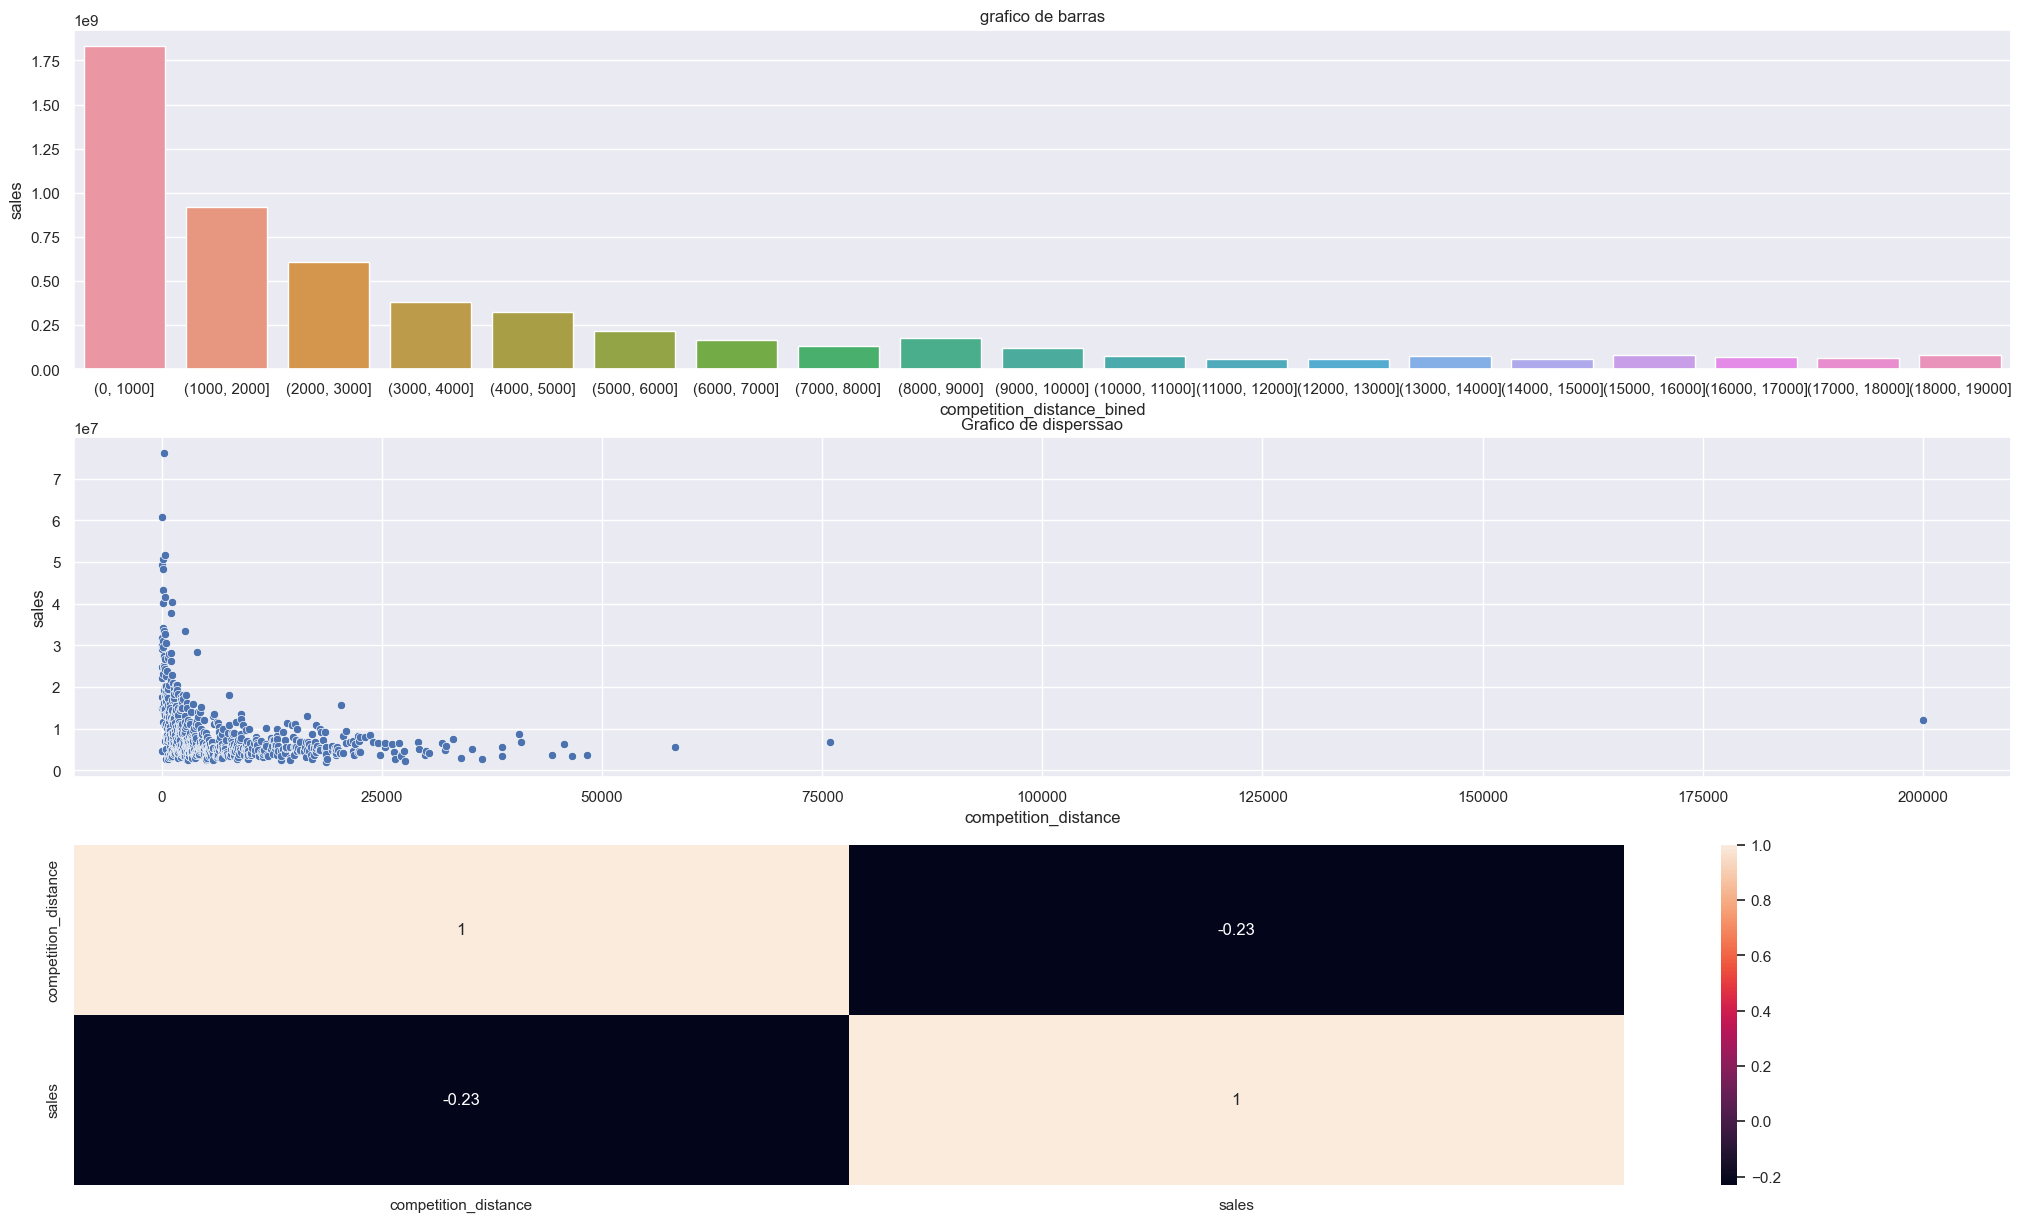

In [90]:
fig,(ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(25, 15))

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_bined'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_bined', 'sales']].groupby('competition_distance_bined').sum().reset_index()

sns.barplot(x='competition_distance_bined', y='sales', data=aux2, ax=ax1);
ax1.set_title('grafico de barras')

aux1 = df4[['competition_distance', 'sales']].groupby(
    'competition_distance').sum().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1, ax=ax2);
ax2.set_title('Grafico de disperssao')

sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax3);

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**False** Lojas com competidores à mais tempo vendem menos.

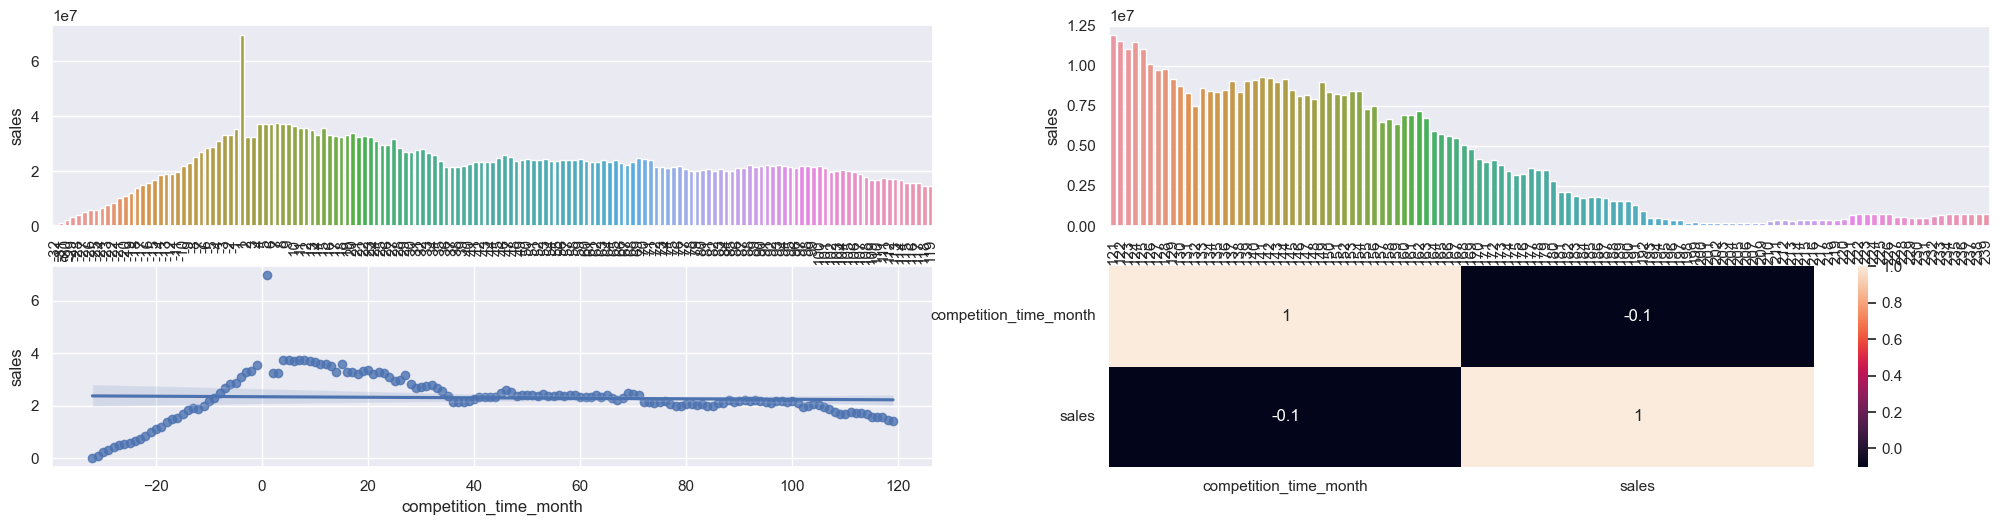

In [91]:
# plot de barras com as variaveis tempo
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()

plt.subplot(4, 2, 1)
# filtro da variavel tempo < 120 !=0
aux2 = aux1[ ( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks( rotation=90);

plt.subplot(4, 2, 2)
# filtro da variavel tempo > 120 e < 240
aux3 = aux1[(aux1['competition_time_month'] > 120) & (aux1['competition_time_month'] < 240 )]
sns.barplot(x='competition_time_month', y='sales', data=aux3);
plt.xticks( rotation=90);

plt.subplot(4, 2, 3)
# grafico de dispersao com linha de regrasao
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(4, 2, 4)
# graphic correlation
aux4 = sns.heatmap( aux1.corr(method='pearson'), annot=True);





**H4.**Lojas com promoções ativas por mais tempo deveriam vender mais.

**Falsa** por que lojas com promo ativas vende menos, depois de um certo periodo de promo

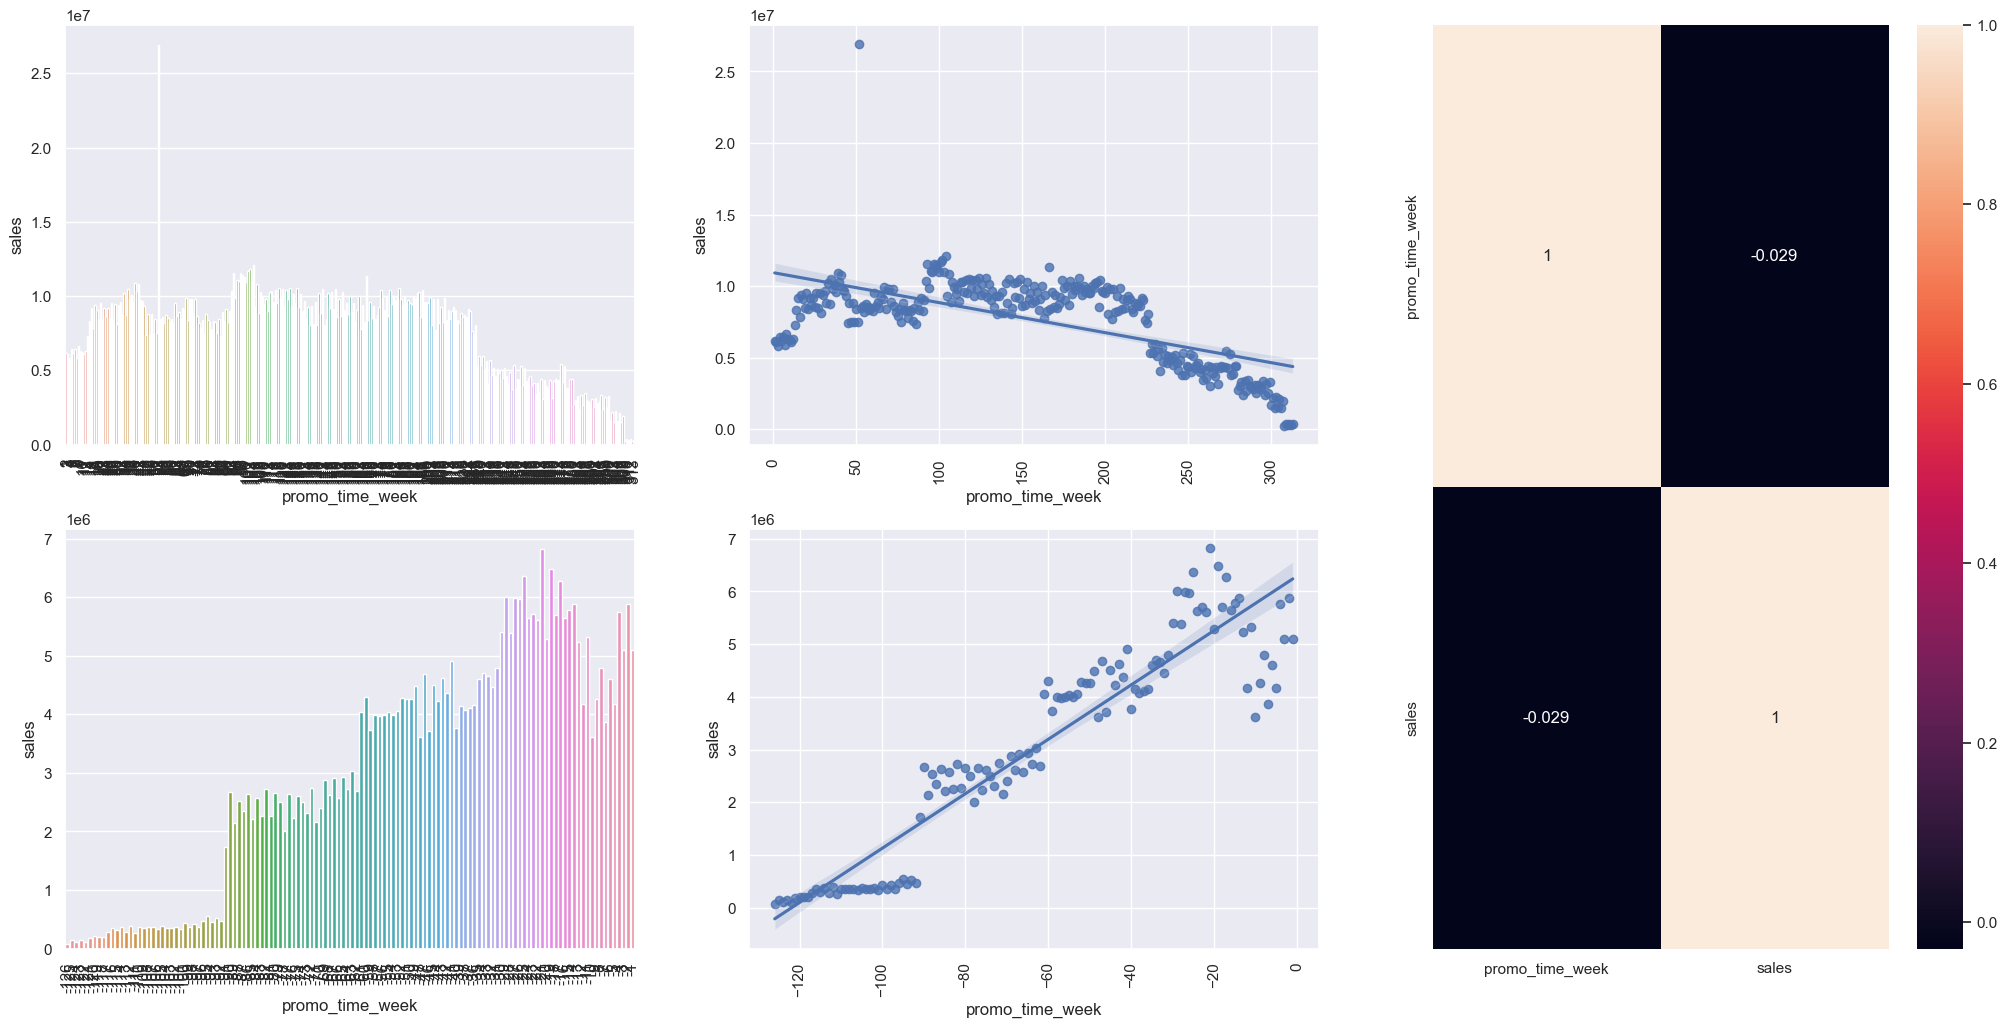

In [92]:


aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

# promo extendido
plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0 ]# promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation= 90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

# promo regular
plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation= 90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**H5.**<s>Lojas com mais dias de promoção deveriam vender mais.</s>

**H7.**Lojas com mais promoções consecutivas deveriam vender mais. 
**Falsa** Lojas com mais promoções consecutivas deveriam vendem menos. 



In [93]:
df4.loc[:, ['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().sort_values(['sales'],ascending=True).reset_index()


,promo,promo2,sales
0,0,1,1289362241
1,1,1,1472275754
2,0,0,1482612096
3,1,0,1628930532


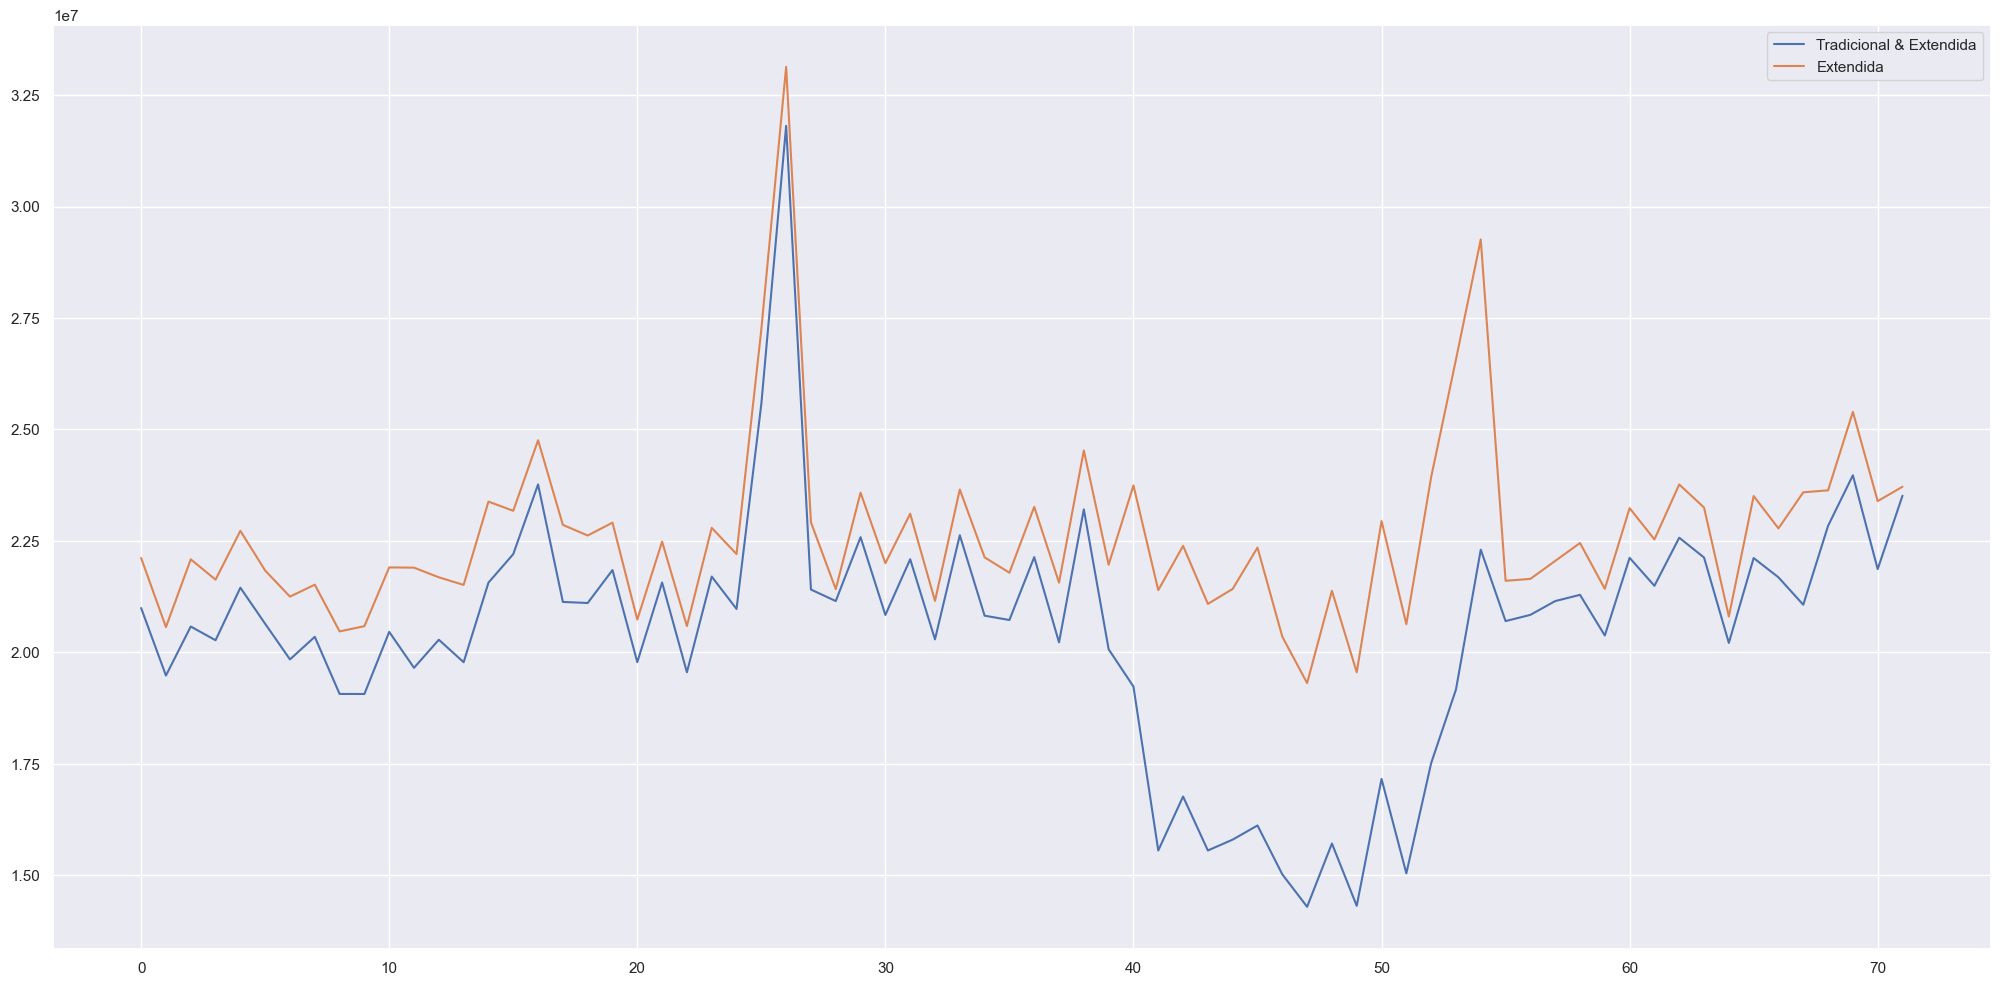

In [94]:
aux1 = df4[(df4['promo'] == 1 )& (df4['promo2'] == 1)][['year_week','sales']].groupby(['year_week']).sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby(['year_week']).sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida','Extendida' ]);



## 4.2. Analise Bivariada

**H8.**Lojas abertas durante o feriado de Natal deveriam vender mais.

**False**Lojas abertas durante o feriado de Natal deveriam vendem menos.


In [95]:
df4.loc[:,['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()


,state_holiday,sales
0,christimas,691806
1,easter_holiday,1433744
2,public_holiday,5890305
3,regular_day,5865164768


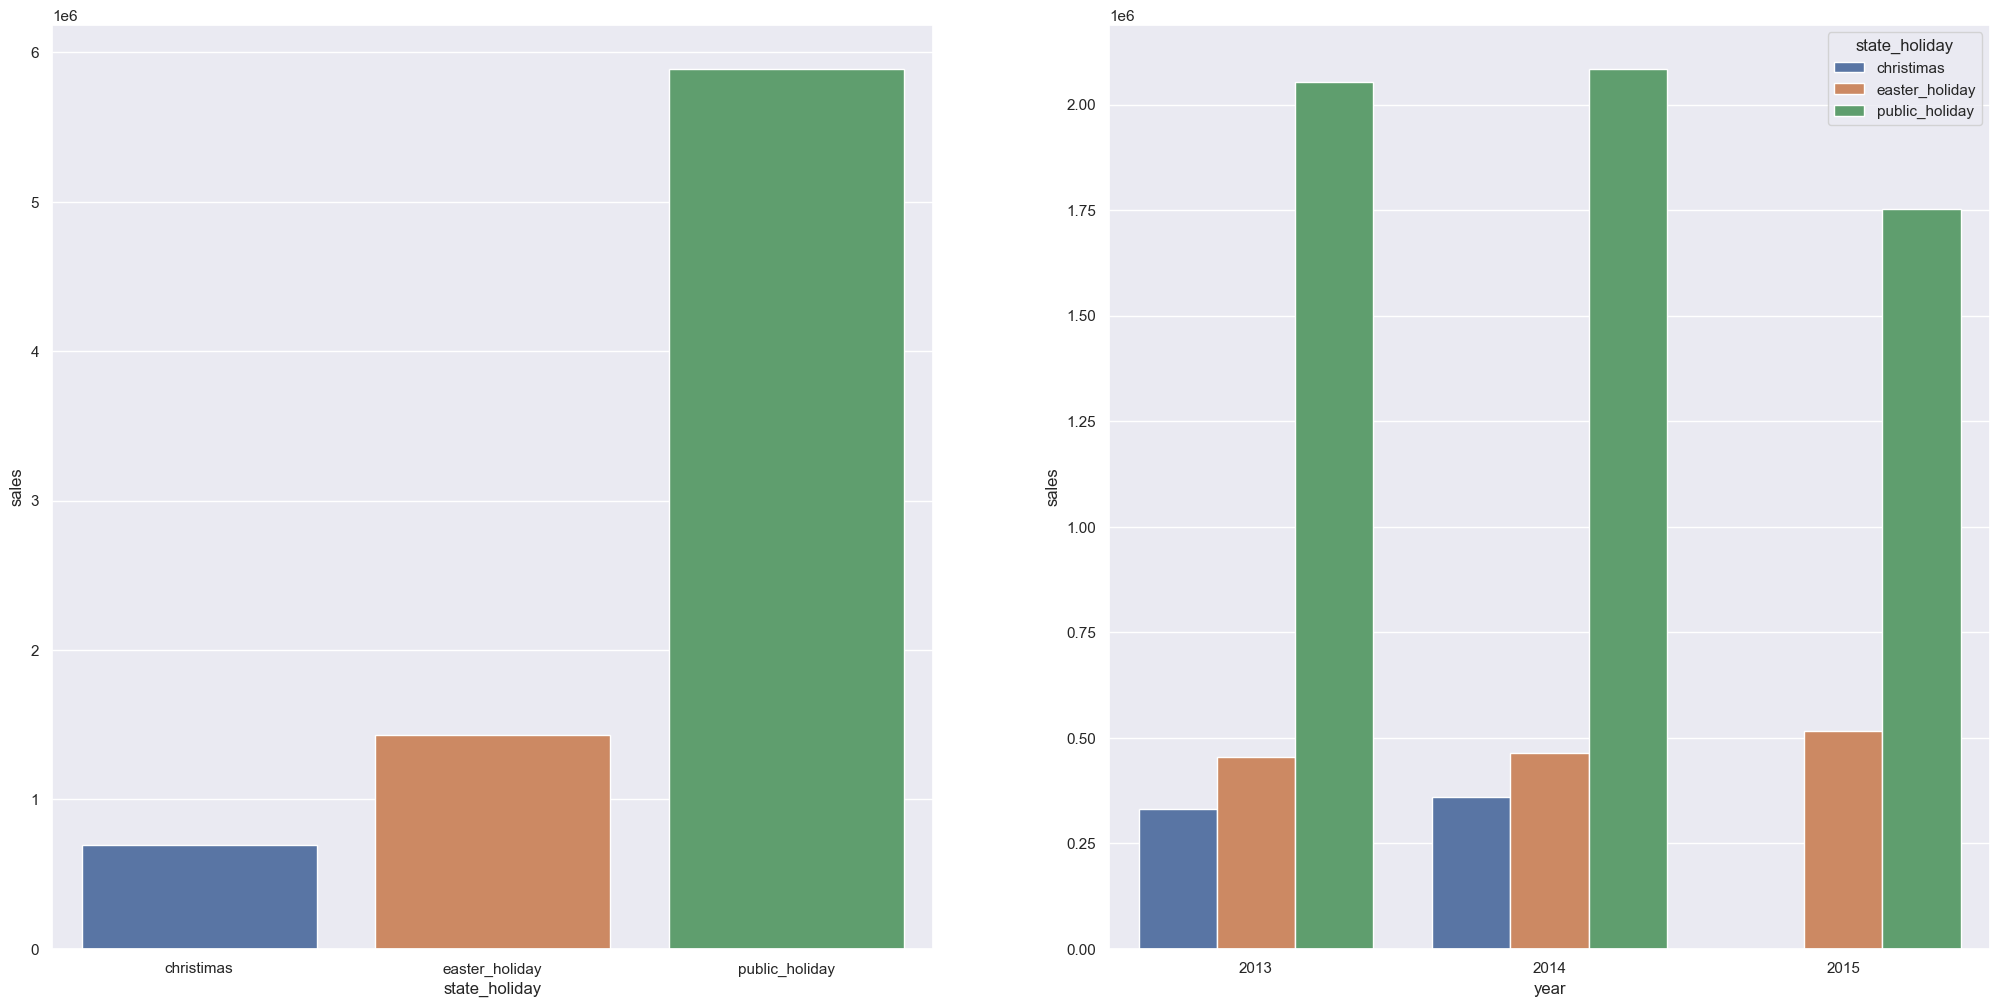

In [96]:
ax = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
ax1 = ax[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=ax1);

plt.subplot(1, 2, 2)
ax2 = ax[['state_holiday','sales','year']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=ax2);

**H9.**Lojas deveriam vender mais ao longo dos anos.

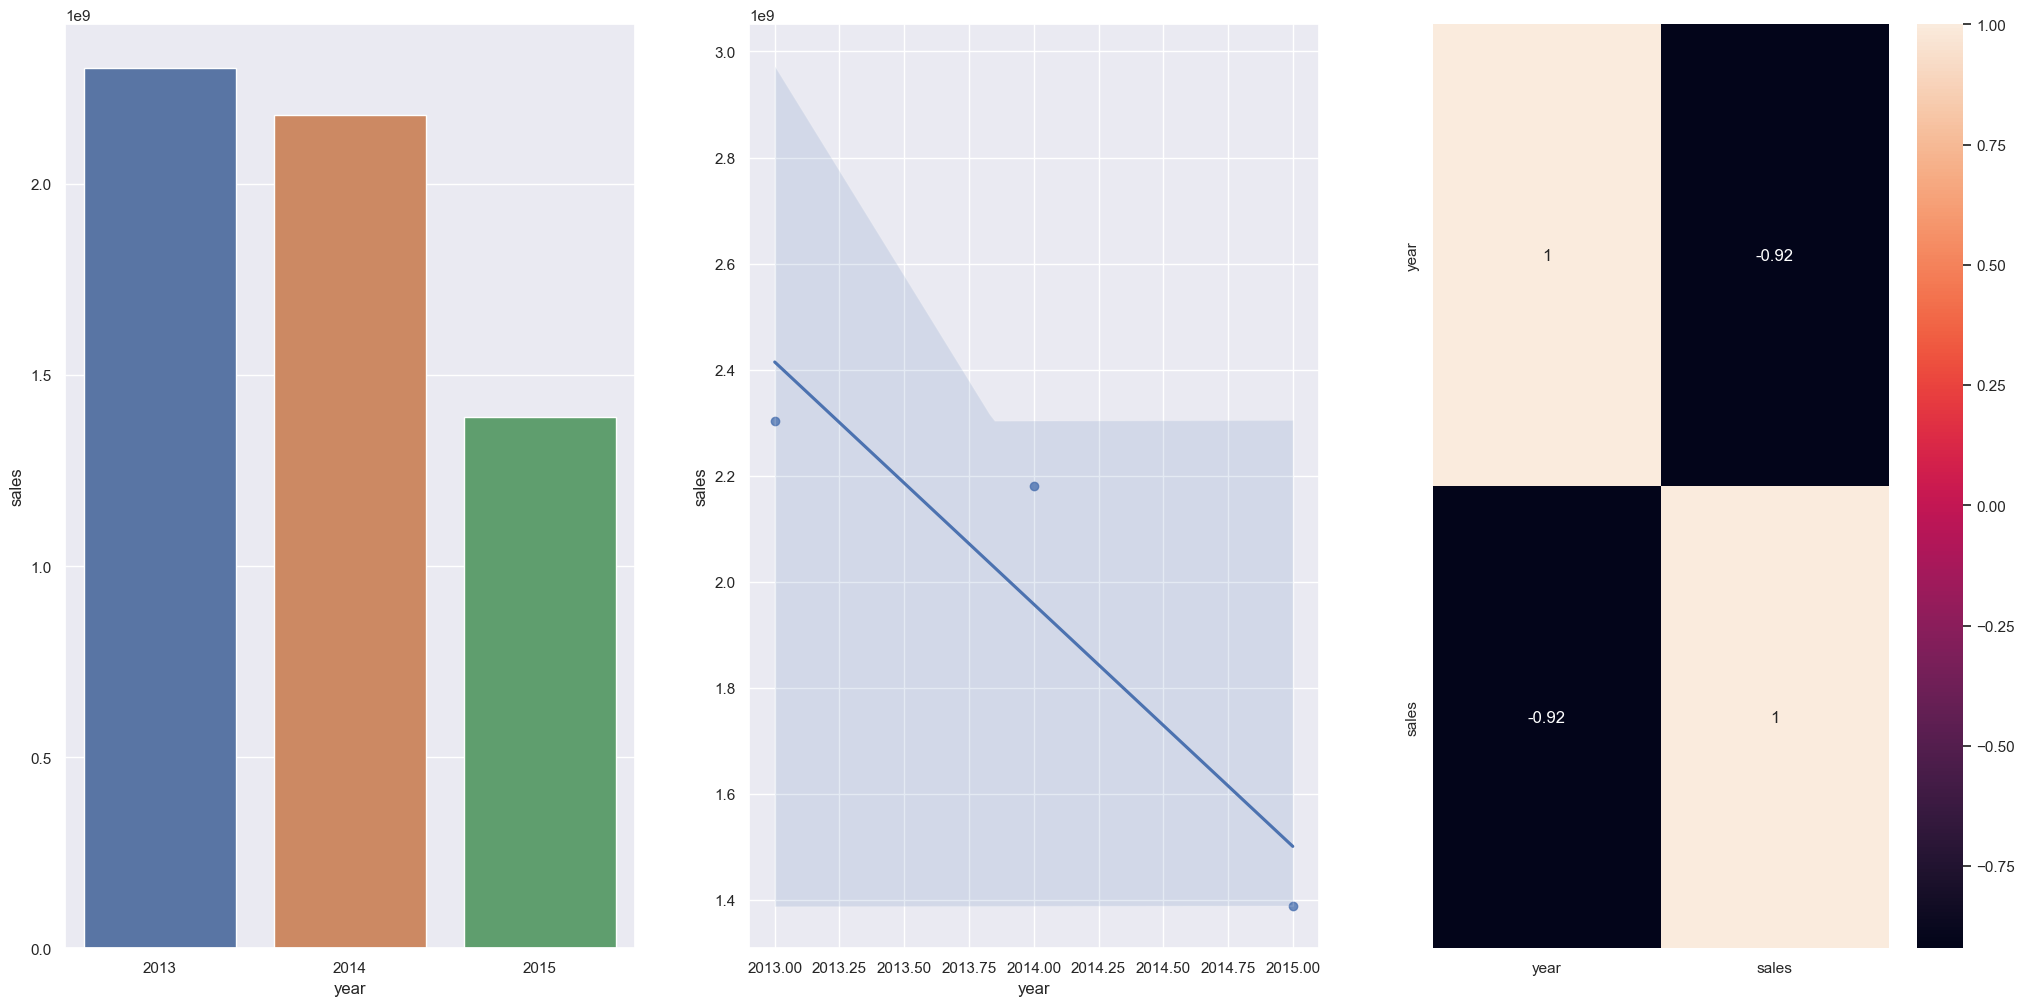

In [97]:
plt.subplot(1,3,1)
ax3 = df4[['sales','year']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=ax3);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=ax3);

plt.subplot(1, 3, 3)
sns.heatmap(ax3.corr(method='pearson'),annot=True);

**H10.** Lojas deveriam vender mais no segundo semestre do ano.

<AxesSubplot:>

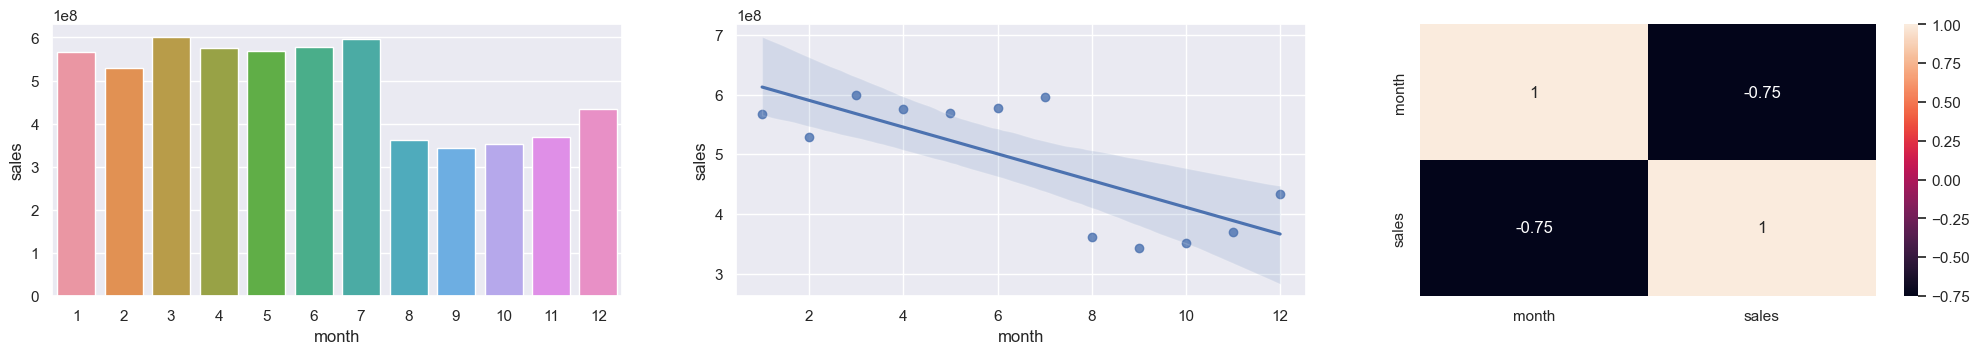

In [98]:
axx = df4[['month', 'sales']].groupby(['month']).sum().reset_index()

plt.subplot(3, 3, 1)
aux3 = axx[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux3)

plt.subplot(3, 3, 2)
sns.regplot(x='month', y='sales', data=aux3)

plt.subplot(3, 3, 3)
sns.heatmap(aux3.corr(method='pearson'), annot=True)


**H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

<AxesSubplot:xlabel='before_after', ylabel='sales'>

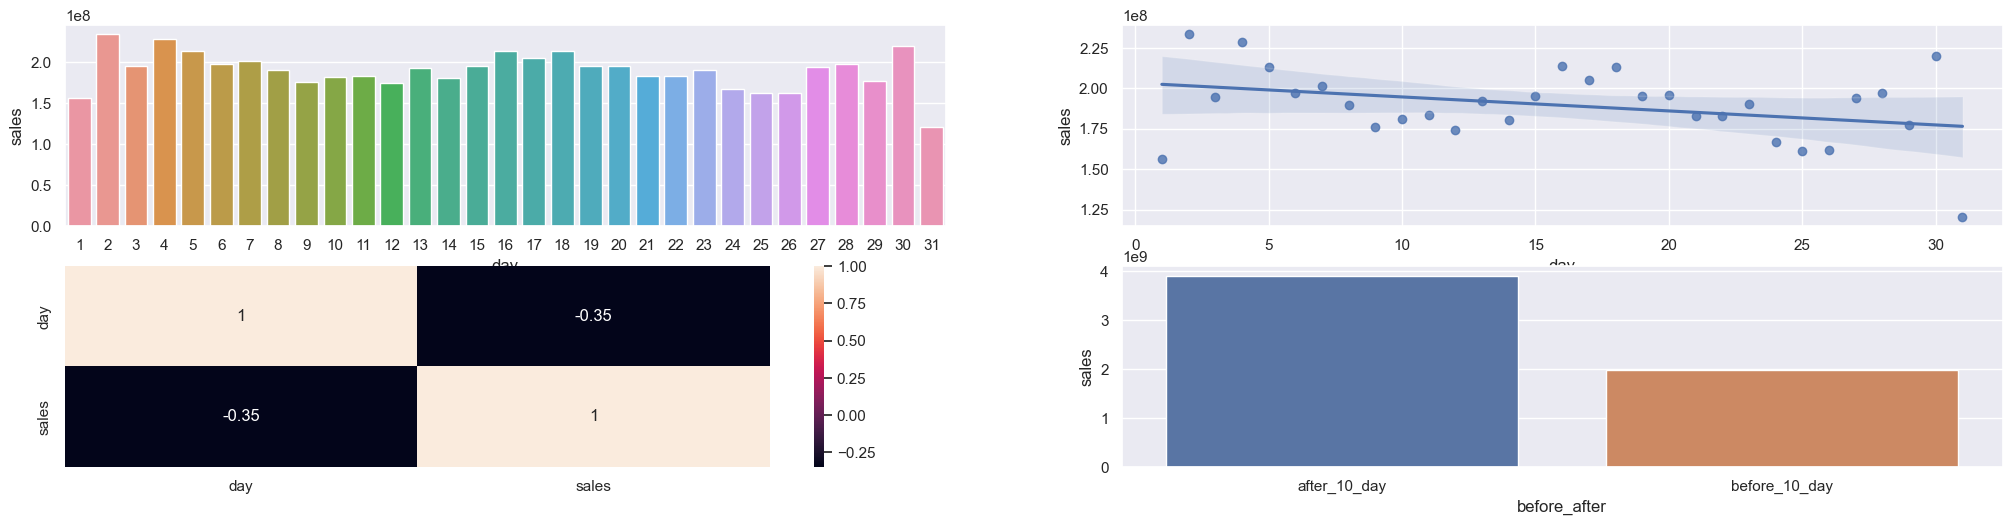

In [99]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(4,2,1)

sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(4,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(4, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_day' if x <= 10 else 'after_10_day')

plt.subplot(4,2,4)
aux4 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux4)









**H12.** Lojas deveriam vender menos aos finais de semana.

<AxesSubplot:>

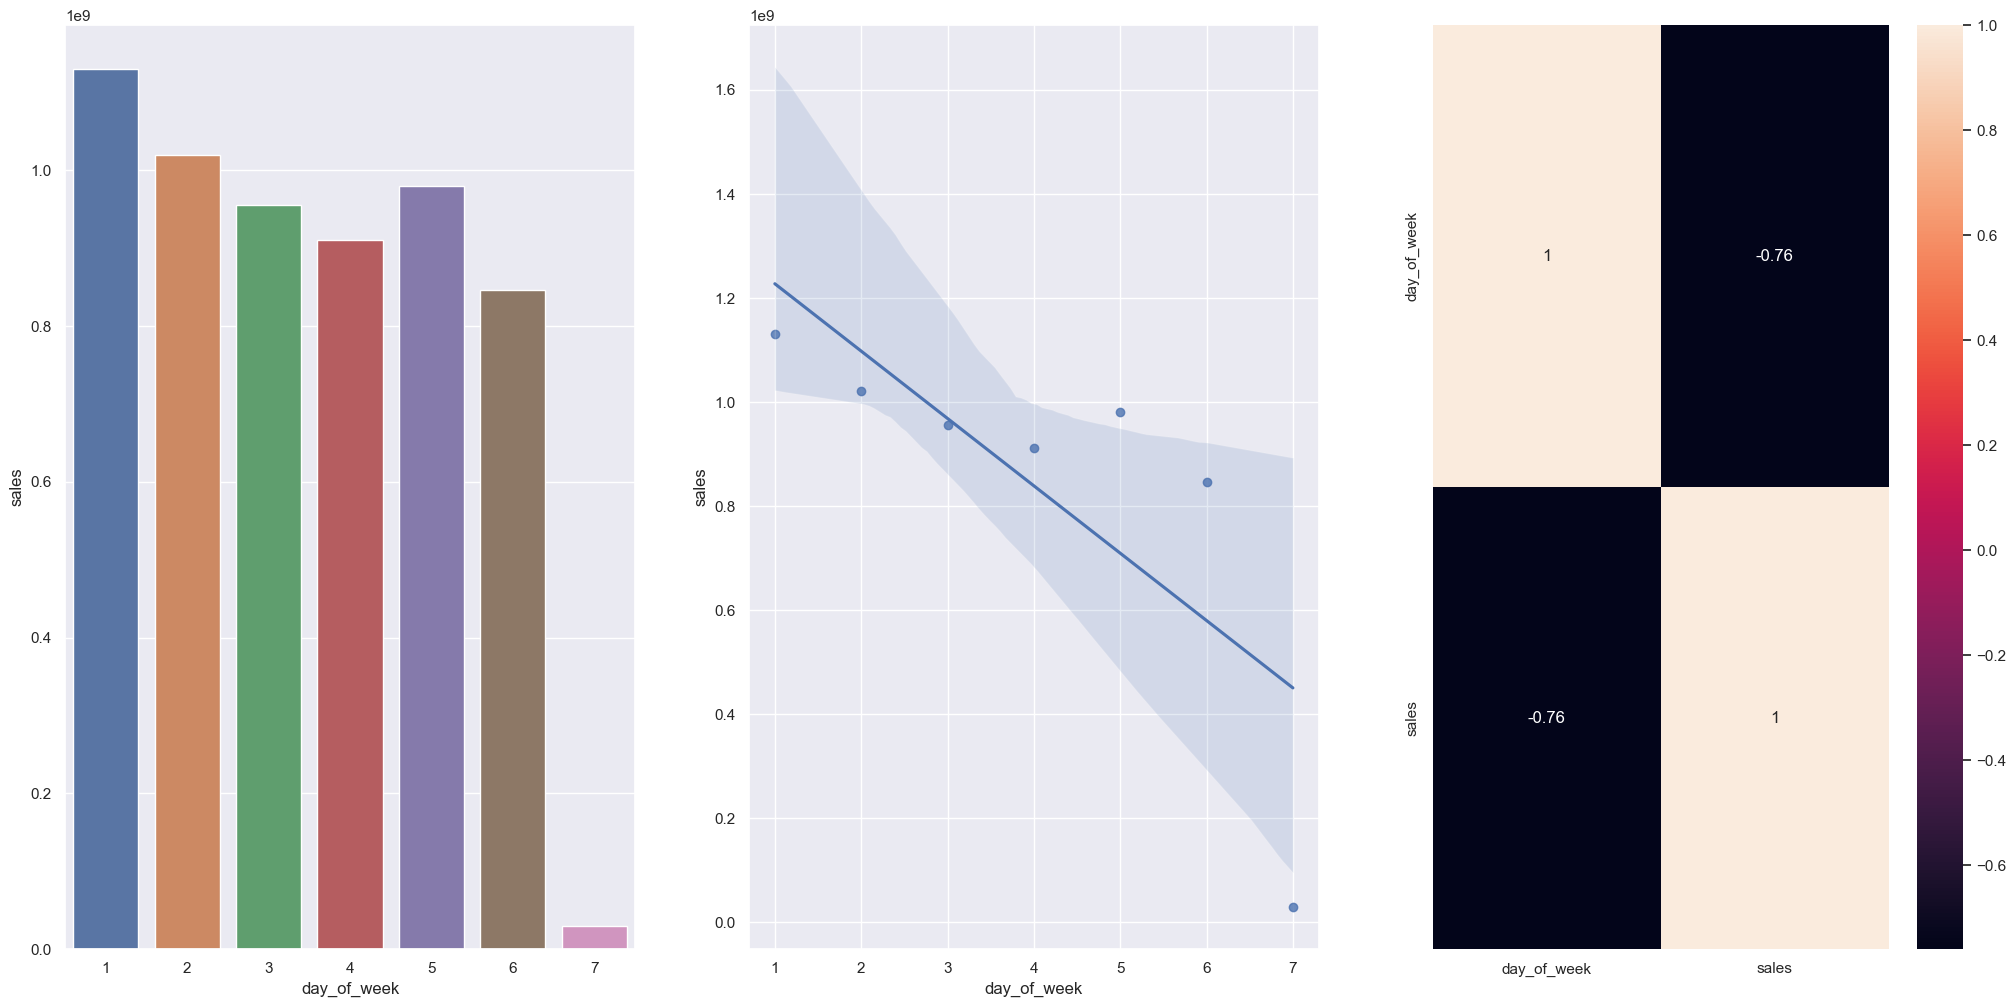

In [100]:
ax = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=ax)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=ax)

plt.subplot(1, 3, 3)
sns.heatmap(ax.corr(method='pearson'), annot=True)

**H13.** Lojas deveriam vender menos durante os feriados escolares.

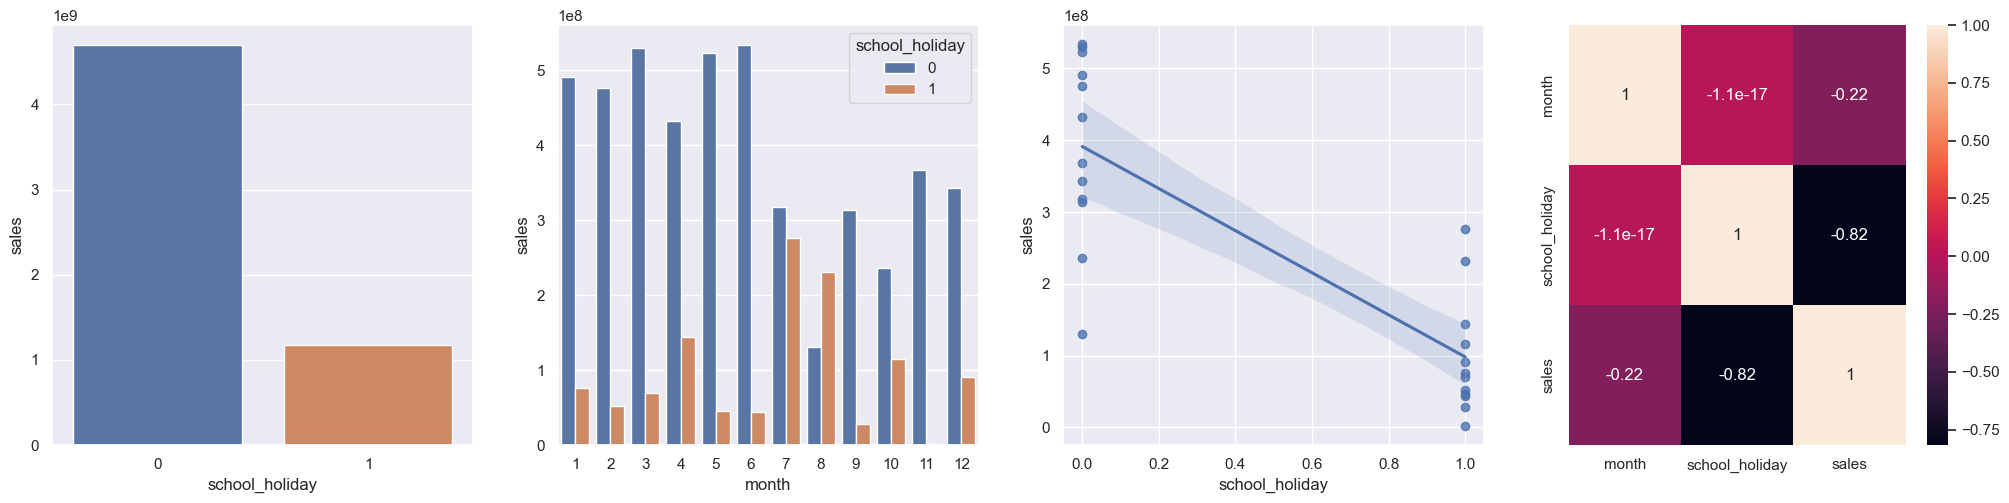

In [101]:
axx = df4[['school_holiday', 'sales']].groupby(['school_holiday']).sum().reset_index()
ax = df4[['school_holiday', 'sales', 'month']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot(2, 4, 1)
sns.barplot(x='school_holiday', y='sales', data=axx)


plt.subplot(2, 4, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=ax);

plt.subplot(2, 4, 3)
sns.regplot(x='school_holiday', y='sales', data=ax);

plt.subplot(2, 4, 4)
sns.heatmap(ax.corr(method='pearson'), annot=True);

In [102]:
from tabulate import tabulate

In [103]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
     ]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3. Analise Multivariada

Ingles:
Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

Portugues:
Index(['loja', 'dia da semana', 'data', 'vendas', 'promoção', 'feriado estadual',
       'férias escolares', 'tipo de loja', 'sortimento', 'distância da competição',
       'concurso aberto desde o mês', 'concurso aberto desde o ano', 'promo2',
       'promo2 desde a semana', 'promo2 desde o ano', 'é promo', 'ano', 'mês',
       'dia', 'semana do ano', 'semana do ano', 'competição desde',
       'mês de tempo de competição', 'promo desde', 'semana de tempo de promoção'],
      dtype='objeto')

## 4.3.1. Numerical Atribuites

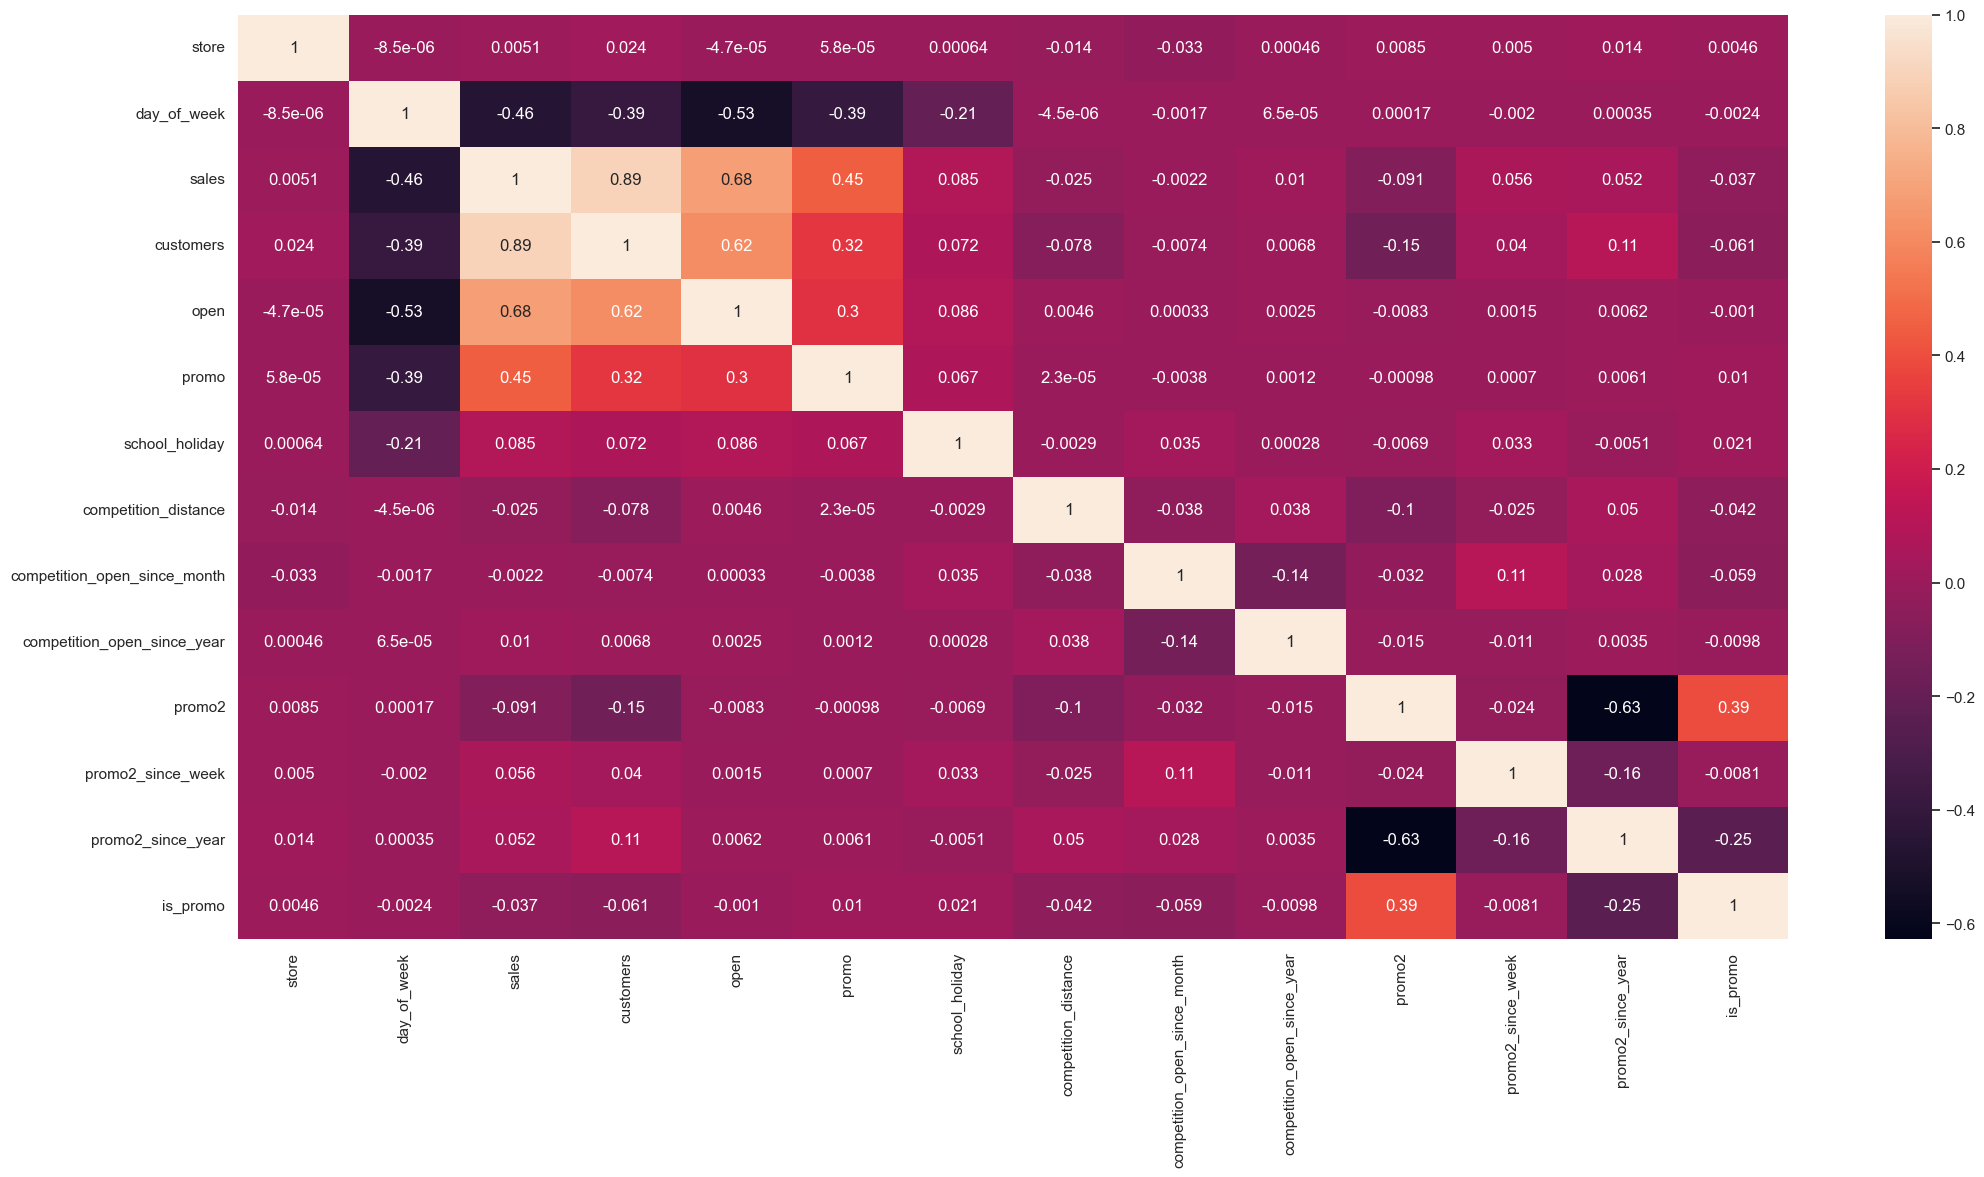

In [104]:
correlation = num_atributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

## 4.3. Categoricas Attributs

In [105]:
new_cat_att = df4.select_dtypes(include='object')
new_cat_att.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


<AxesSubplot:>

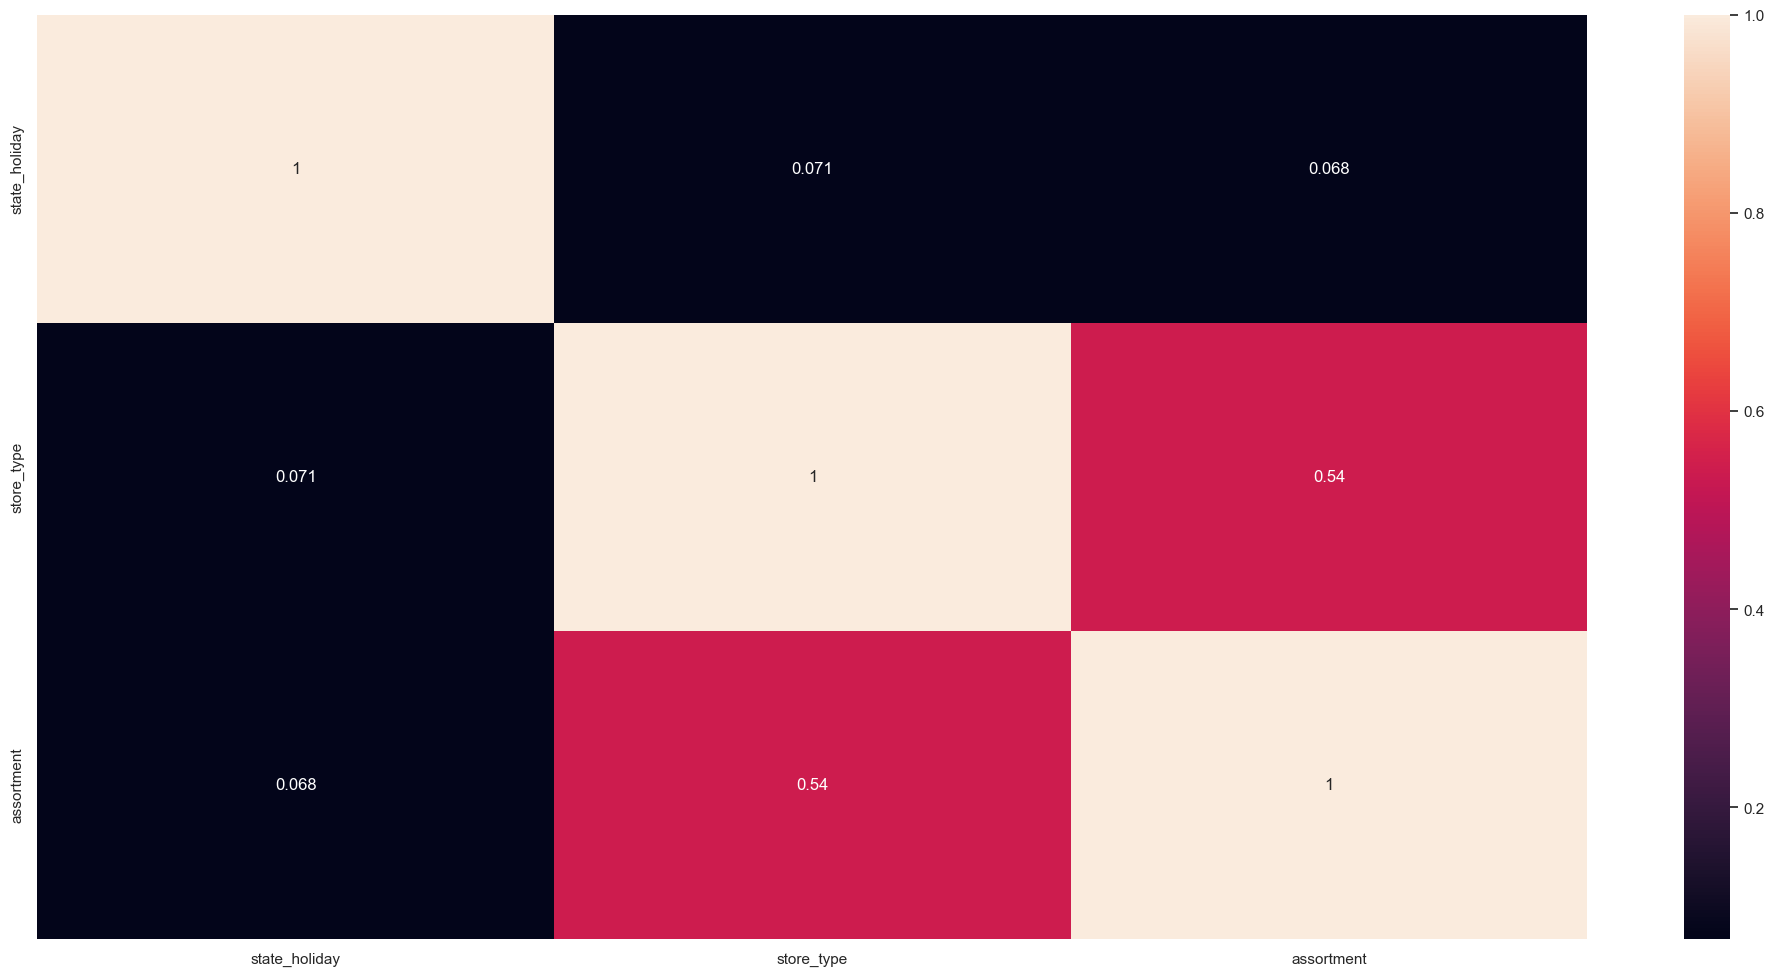

In [114]:
# only categorical data
cat_df = df4.select_dtypes(include='object')
a1 = cramer_v(cat_df['state_holiday'], cat_df['state_holiday'])
a2 = cramer_v(cat_df['state_holiday'], cat_df['store_type'])
a3 = cramer_v(cat_df['state_holiday'], cat_df['assortment'])
a4 = cramer_v(cat_df['store_type'], cat_df['state_holiday'])
a5 = cramer_v(cat_df['store_type'], cat_df['store_type'])
a6 = cramer_v(cat_df['store_type'], cat_df['assortment'])
a7 = cramer_v(cat_df['assortment'], cat_df['state_holiday'])
a8 = cramer_v(cat_df['assortment'], cat_df['store_type'])
a9 = cramer_v(cat_df['assortment'], cat_df['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]})
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)


# 5.0.0 Data Preparation

In [159]:
df5 = df4.copy()


## 1. Normalizacao 


    * para distribuicao normal.

 X new = Xi - µ / o

    - a variavel menos a media dividido pelo desvio padrao.

* µ = media
* o = desvio padrao
 - pega todos os valores da coluna soma e div pela qtd de valores = média.

 #### Calculo de desvio padrao
 * Quando se tem a media e o desvio padrao.

    - Pega o o primeiro valor de uma coluna subtrai a media e dividir pelo desvio padrao, o resultado desse calculo e um novo valor, ou seja tras o vl antido para uma nova escala
    coluna normalizada.

### 2.Min-Max Scaler
    * Nao tem distribuicao normal
Xnew = Xi - µ / Xmax - Xmin

µ = média

    * pega a col que sera aplicado o metodo , pega a coluna encontra a media de valores somando e dividindo pela qquantidade de valores a media somando todos os vl e dividindo pelo quantidade dos vl, pega o vl max e o vl min


### A normalização
 de dados é um processo utilizado para colocar todas as variáveis em uma escala comum. Existem diferentes técnicas de normalização, mas aqui estão algumas das mais comuns:

    #### Normalização Min-Max:
Encontre os valores mínimo e máximo da variável que deseja normalizar.
Subtraia o valor mínimo do valor que deseja normalizar.
Divida o resultado pelo intervalo entre o valor máximo e mínimo.
O resultado será a variável normalizada, que estará entre 0 e 1.

    #### Normalização Z-score:
Encontre a média e o desvio padrão da variável que deseja normalizar.
Subtraia a média do valor que deseja normalizar.
Divida o resultado pelo desvio padrão.
O resultado será a variável normalizada, que terá média 0 e desvio padrão 1.

    #### Normalização Decimal:
Encontre o maior valor absoluto da variável que deseja normalizar.
Divida todos os valores pela potência de 10 mais próxima do maior valor absoluto.
O resultado será a variável normalizada, que terá um valor máximo absoluto de 1.

    #### Essas são algumas das técnicas de normalização mais comuns, mas existem outras, como a normalização por escala logarítmica e a normalização por quartis. A escolha da técnica depende do tipo de dados que você está trabalhando e do objetivo da normalização. 



### Tipos de preparação dos dados

Existem vários tipos de preparação dos dados, que são aplicados antes da análise de dados ou da modelagem estatística. Aqui estão alguns dos tipos mais comuns de preparação dos dados:

Limpeza de dados:
Identificação e correção de dados ausentes, inconsistentes, incorretos ou duplicados.
Transformação de dados:
Transformação de dados em formatos mais adequados para análise ou modelagem, como converter dados categóricos em dados numéricos, ou converter dados em diferentes unidades de medida.
Seleção de dados:
Seleção de um subconjunto dos dados para análise, com base em critérios específicos, como a relevância para o problema de pesquisa ou a representatividade da amostra.
Redução de dados:
Redução da dimensão dos dados para tornar mais simples a análise, utilizando técnicas como a análise de componentes principais (PCA) ou análise fatorial.
Criação de novas variáveis:
Criação de novas variáveis que não estavam originalmente presentes nos dados, mas que são relevantes para o problema de pesquisa ou para a modelagem estatística.
Normalização de dados:
Normalização de dados para colocá-los em uma escala comum, para facilitar a comparação e a análise.
Essas são algumas das principais técnicas de preparação dos dados, mas a escolha das técnicas a serem utilizadas depende do tipo de dados e do objetivo da análise.

## 5.1.0 Normalizaçao

## 5.2.0  Rescaling

In [160]:
a = df5.select_dtypes( include=['int64', 'float64'])

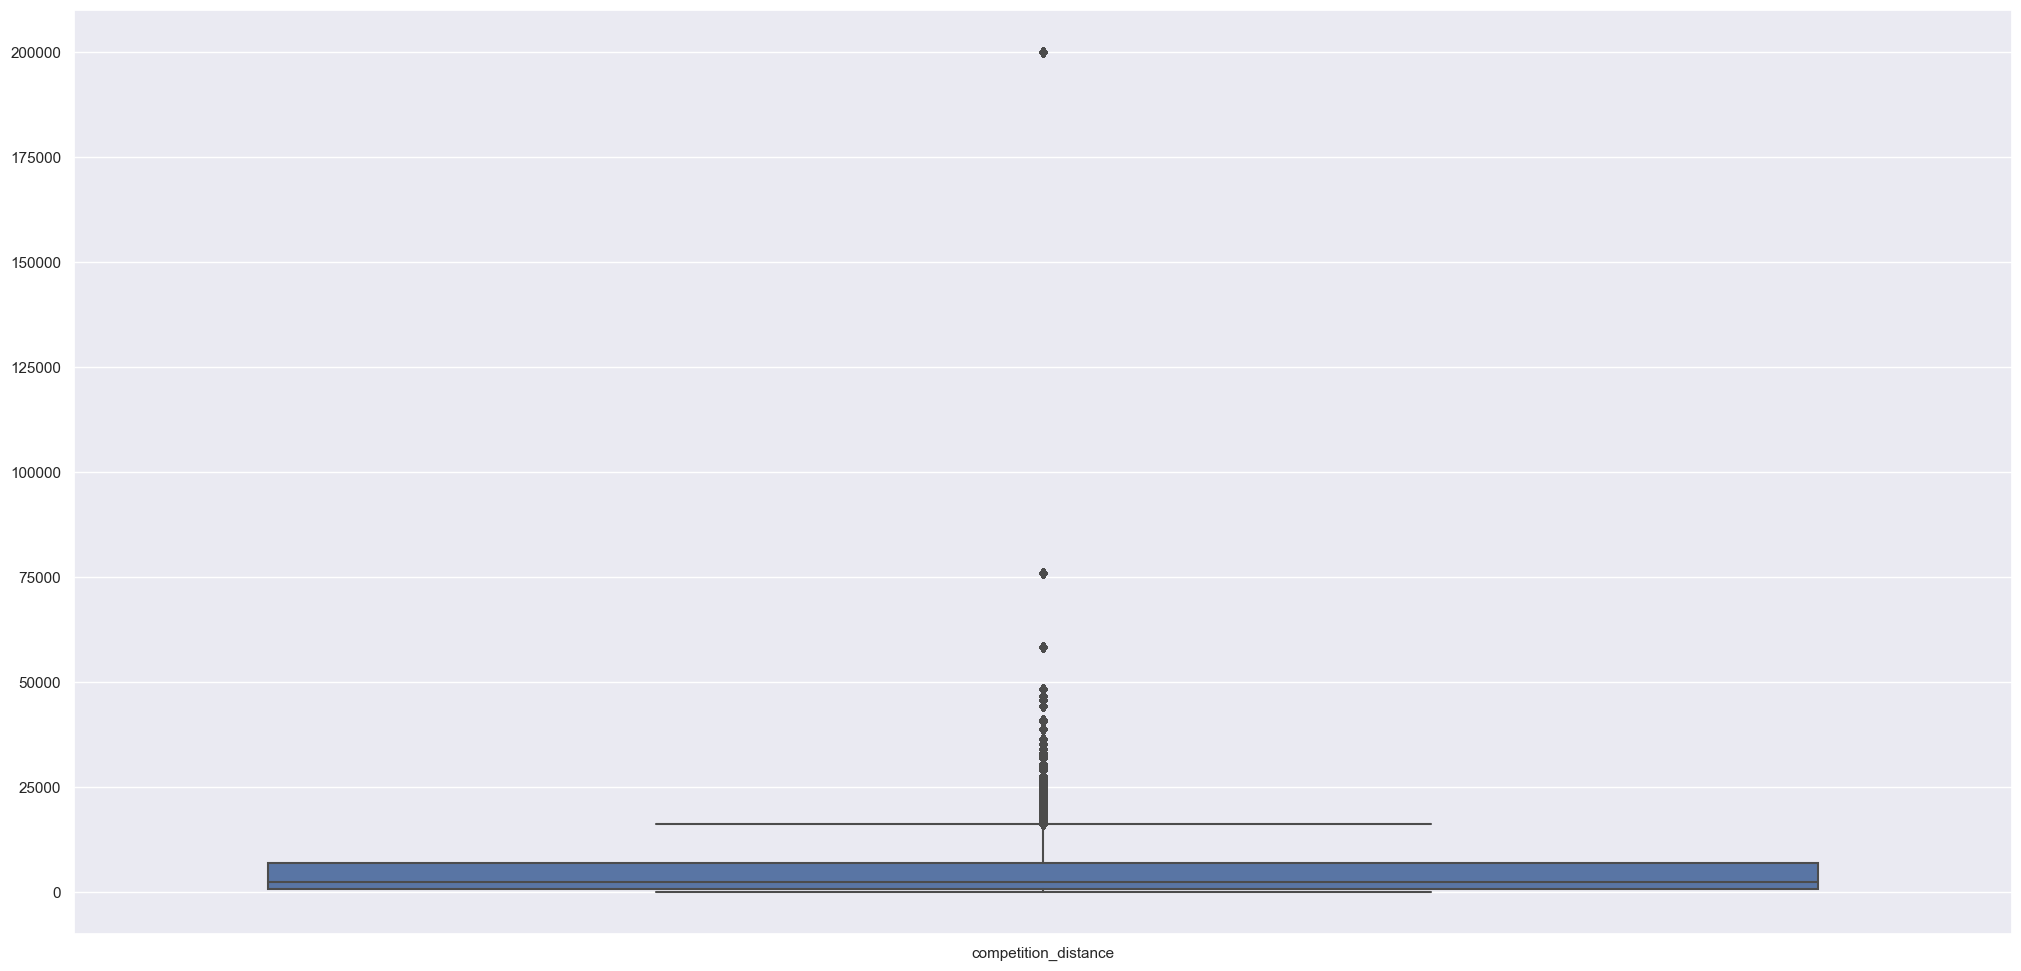

In [161]:
sns.boxplot(df5[['competition_distance']]);

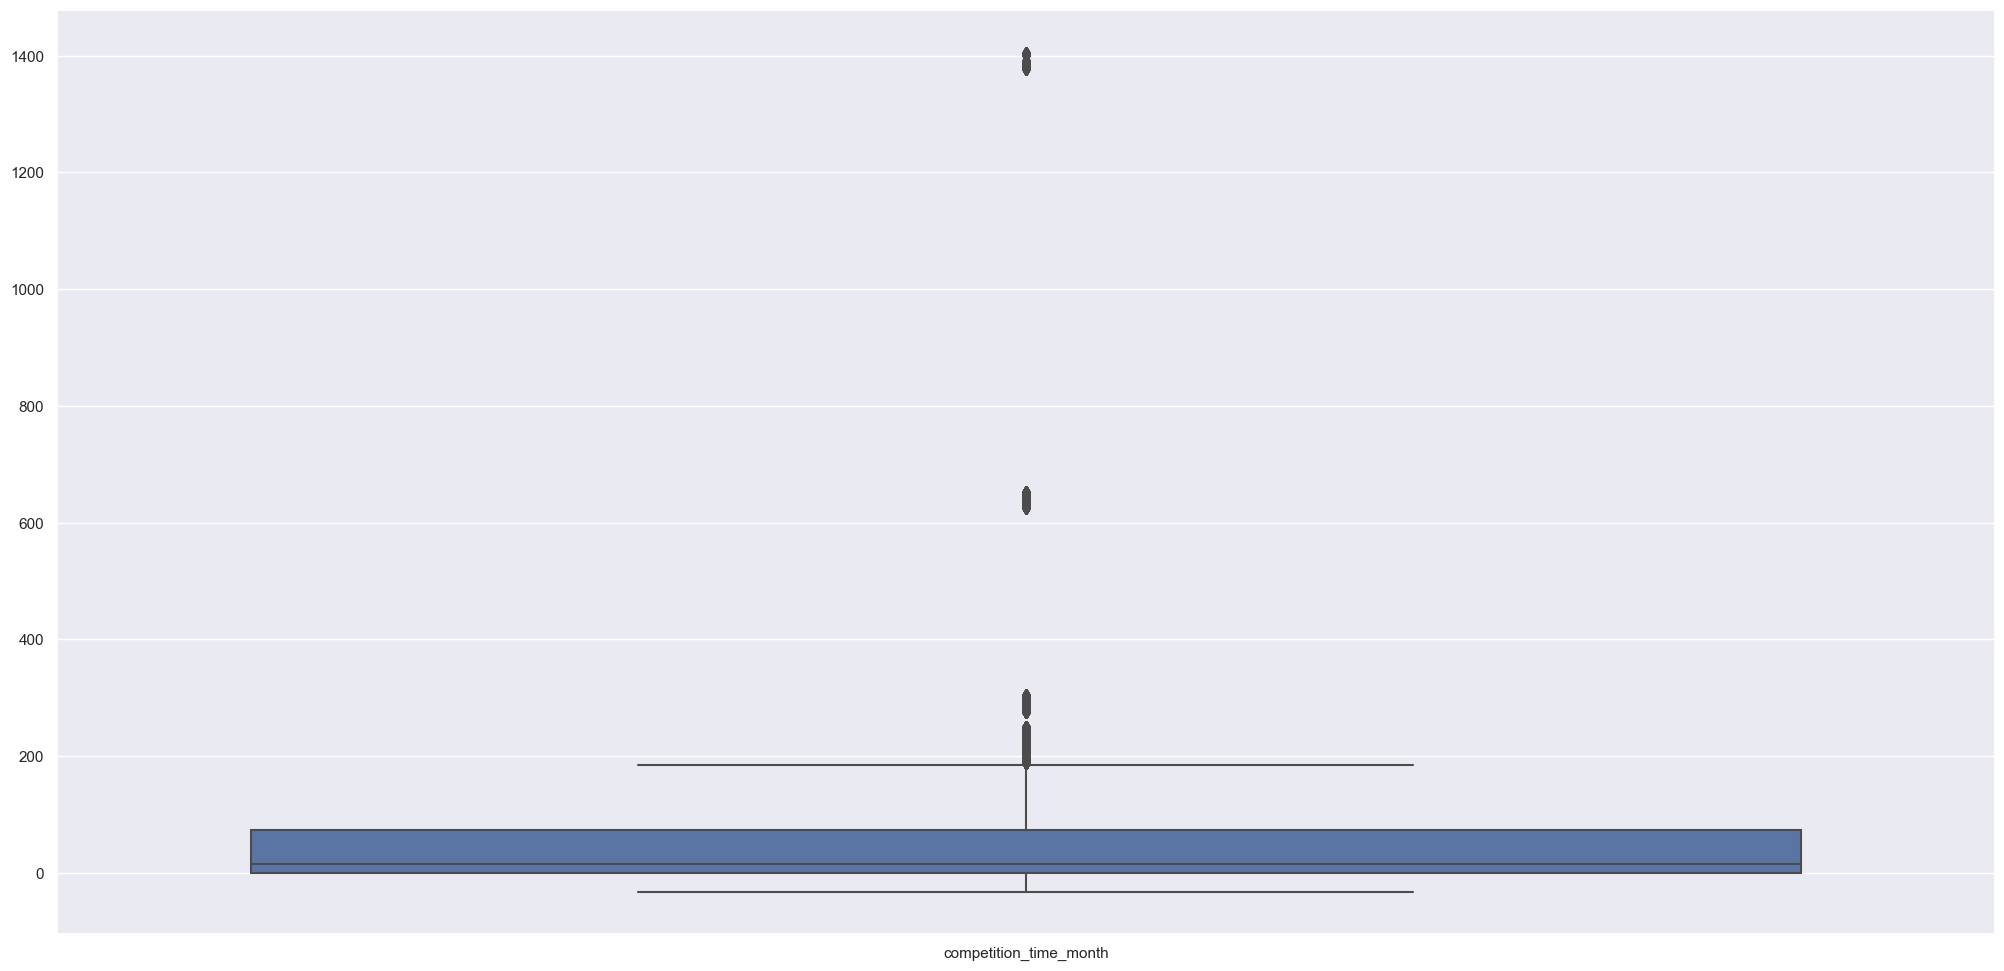

In [162]:
sns.boxplot(df5[['competition_time_month']]);


<AxesSubplot:>

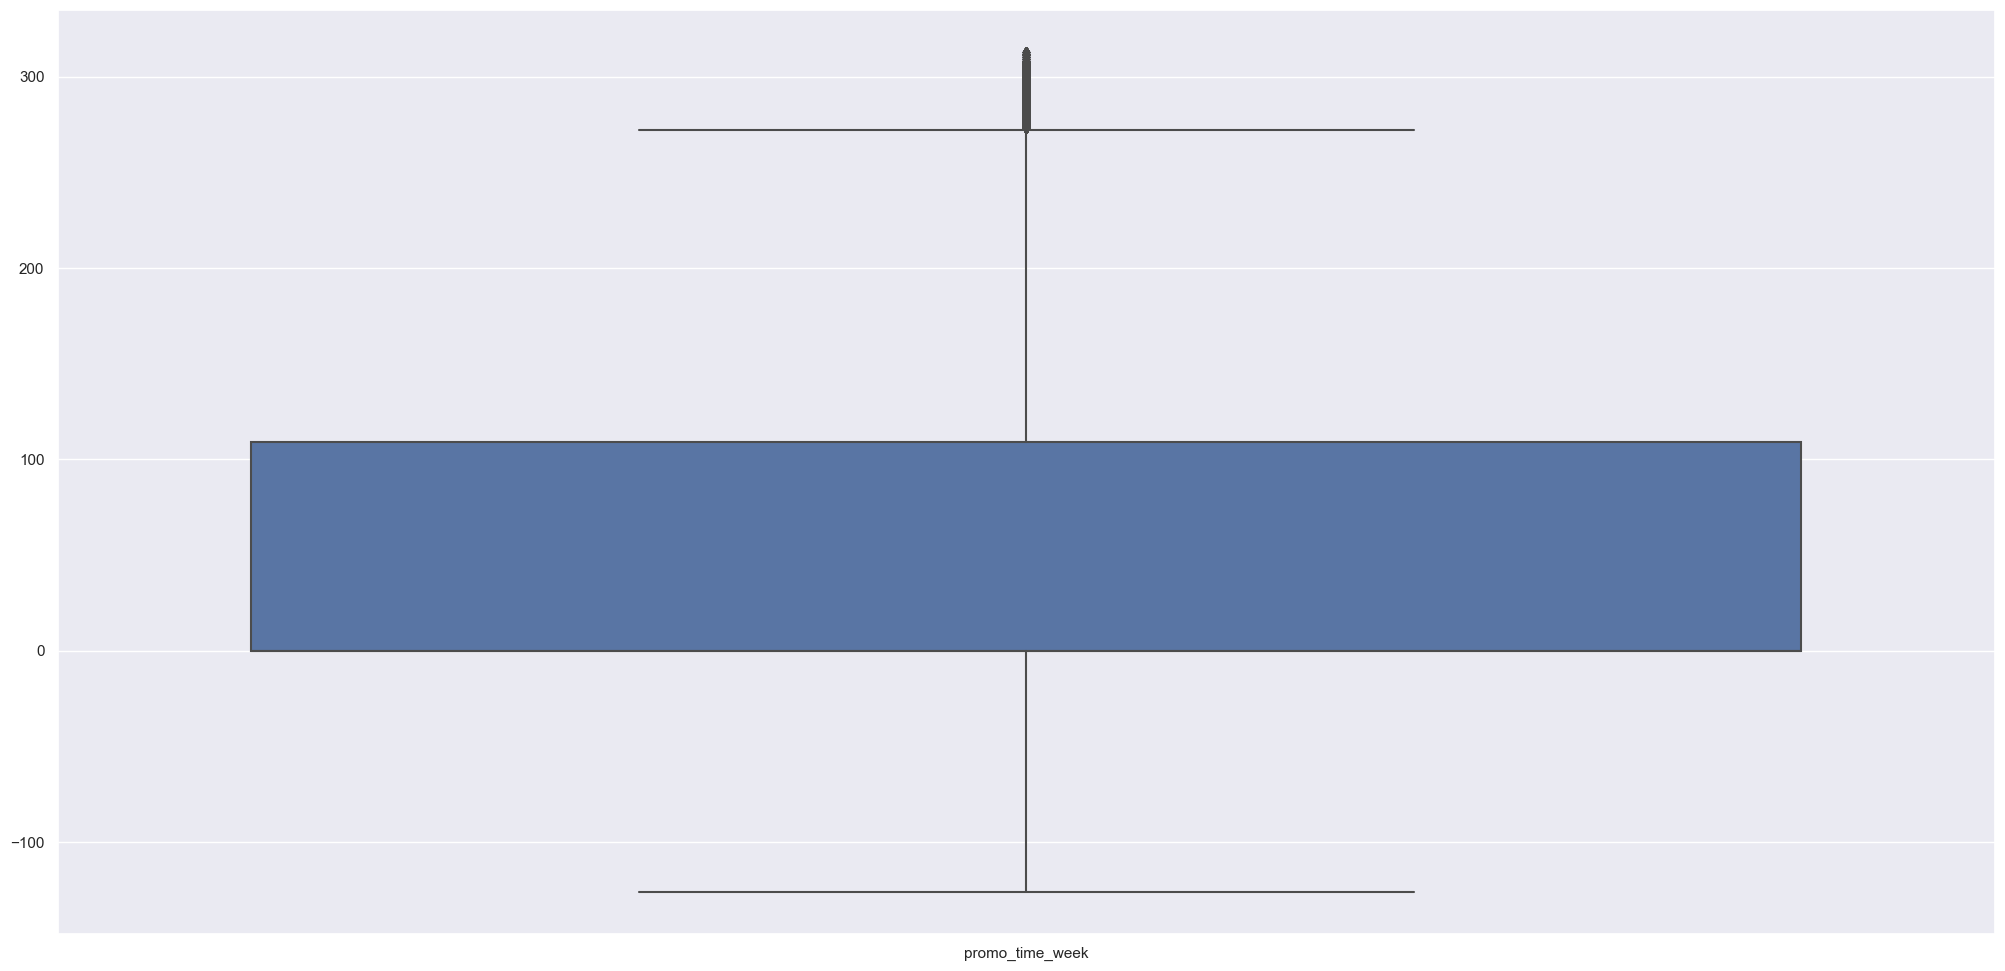

In [163]:
sns.boxplot(df5[['promo_time_week']])


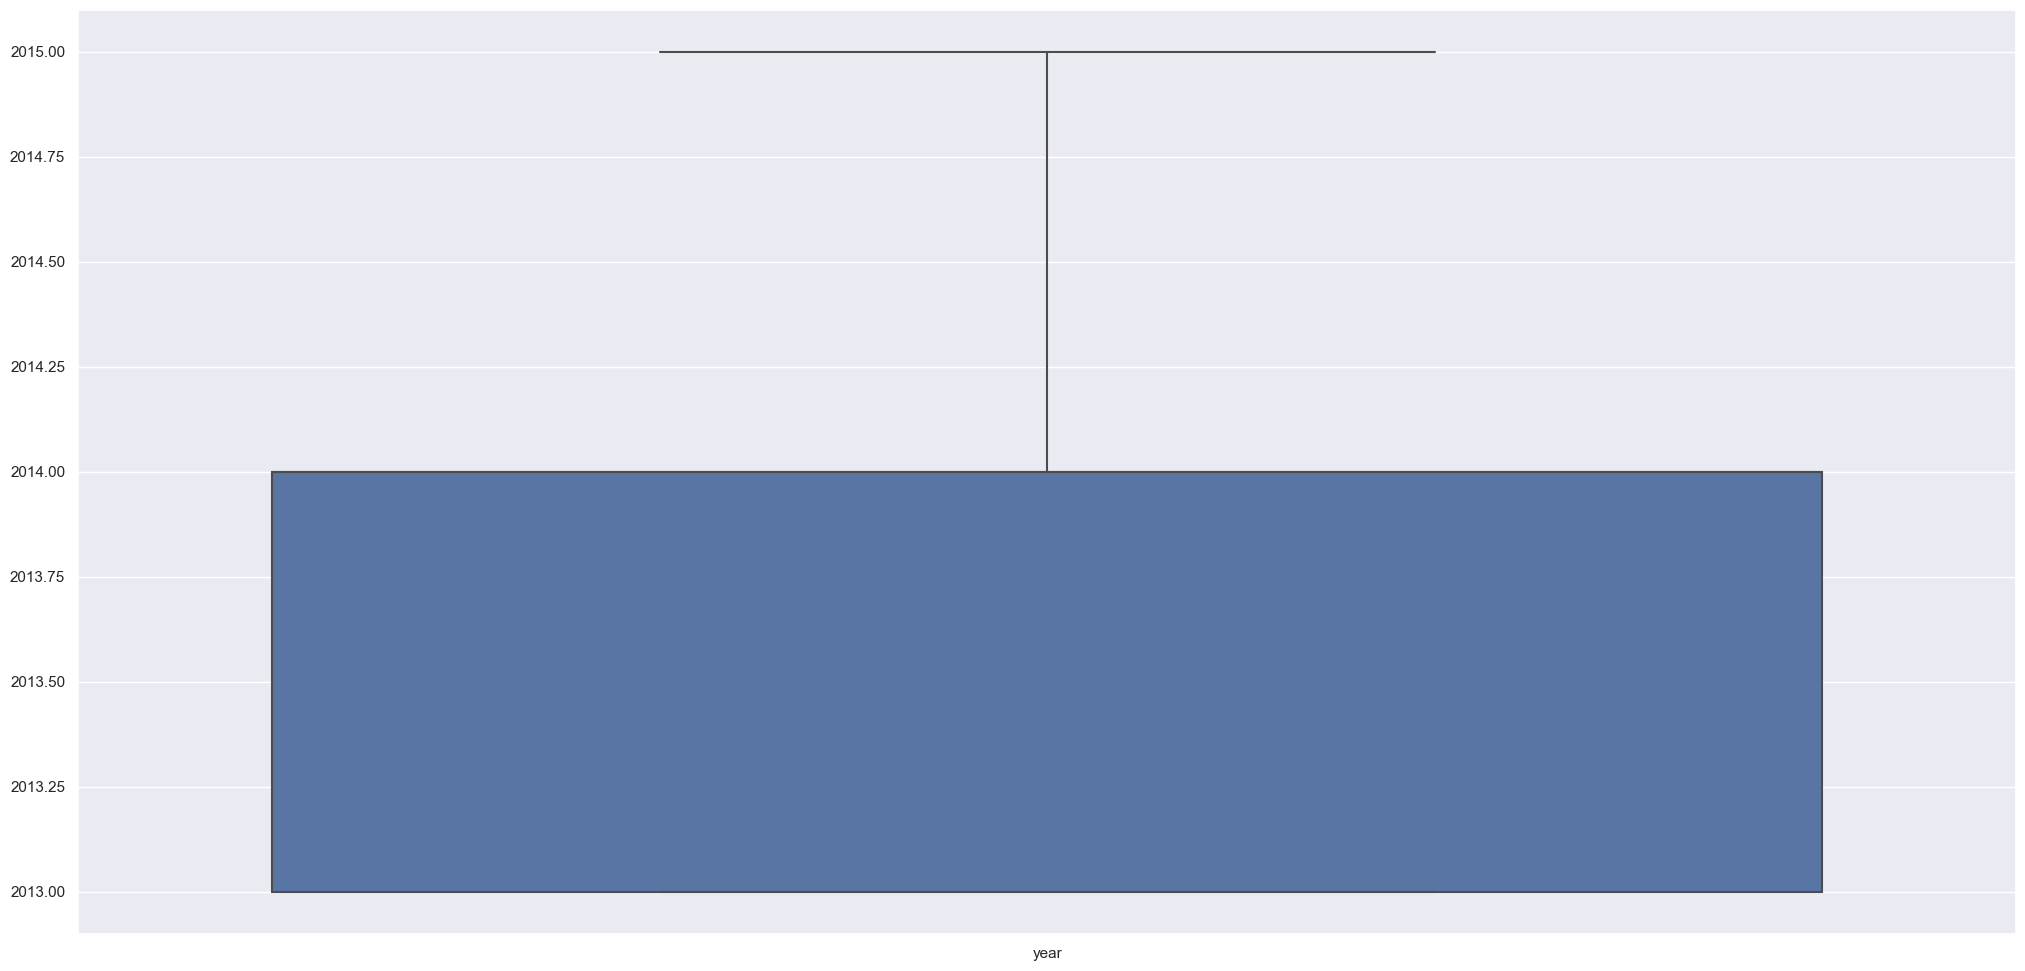

In [164]:
sns.boxplot(df5[['year']]);

In [165]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [166]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition Distace
df5['competition_distance'] = rs.fit_transform(
    df5[['competition_distance']].values)
# Competition Time Month
df5['competition_time_month'] = rs.fit_transform(
    df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# Year
df5['year'] = mms.fit_transform(df5[['year']].values)


## 5.3.3 Transformation

### 5.3.1 Encoding

In [167]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [168]:
df5['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

In [169]:
# lembrando estao em estado repetitivos

# state_holiday = One hot Encoding
df5 = pd.get_dummies( df3,prefix=['state_holiday'], columns=['state_holiday'])

# assortment = Label Encoding
assortmnet_dict = {'basic': 1,'extended': 2,'extra': 3}
df5['assortment'] = df5['assortment'].map(assortmnet_dict)

# store_type = Ordinal Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

In [170]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christimas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,2,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0,0,0,0,1


In [171]:
# Month

# Day

#Week of year

# Day of Week

### 5.3.2 Response Variable Trasnformation

In [172]:
# Transformation the variable response
df5['sales'] = np.log1p(df5['sales'])

### 5.3.2 Nature Transformation

In [173]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christimas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,8.568646,1,1,2,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0,0,0,0,1
1,2,5,2015-07-31,8.710290,1,1,0,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279,0,0,0,1
2,3,5,2015-07-31,9.025816,1,1,0,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226,0,0,0,1
3,4,5,2015-07-31,9.546527,1,1,2,2,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0,0,0,0,1
4,5,5,2015-07-31,8.481151,1,1,0,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0,0,0,0,1


In [174]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))


In [175]:
df5.sample(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christimas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
874976,487,3,2013-05-08,8.847791,0,0,3,2,2180.0,9,2012,1,40,2012,0,2013,5,8,19,2013-18,2012-09-01,8,2012-09-24,32,0,0,0,1,0.433884,-0.900969,0.5,0.5,9.945219e-01,9.945219e-01,0.748511,0.748511
325222,19,6,2014-09-27,8.258681,0,0,0,2,3240.0,9,2014,1,22,2011,0,2014,9,27,39,2014-38,2014-09-01,0,2011-05-23,174,0,0,0,1,-0.781831,0.623490,-1.0,-1.0,-5.877853e-01,-5.877853e-01,-1.000000,-1.000000
95713,939,4,2015-05-07,8.726157,1,0,3,1,1340.0,5,2015,0,19,2015,0,2015,5,7,19,2015-18,2015-05-01,0,2015-05-04,0,0,0,0,1,-0.433884,-0.900969,0.5,0.5,9.945219e-01,9.945219e-01,0.748511,0.748511
984280,521,3,2013-01-30,8.217169,0,0,3,1,18610.0,11,2002,1,48,2011,0,2013,1,30,5,2013-04,2002-11-01,124,2011-11-21,62,0,0,0,1,0.433884,-0.900969,0.5,0.5,-2.449294e-16,-2.449294e-16,0.568065,0.568065
724494,530,5,2013-09-20,8.395703,0,0,0,2,18160.0,9,2013,0,38,2013,0,2013,9,20,38,2013-37,2013-09-01,0,2013-09-16,0,0,0,0,1,-0.974928,-0.222521,-1.0,-1.0,-8.660254e-01,-8.660254e-01,-0.992709,-0.992709
